# Часть 1

## Imports and Configuration

In [1]:
# ---------- Imports ---------- #
import os
from dotenv import load_dotenv
from pathlib import Path
import json
import joblib
import mlflow
from mlflow.models.signature import infer_signature

import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBClassifier
from causalml.inference.meta import BaseTClassifier, BaseXClassifier
import optuna

from sklift.metrics import uplift_auc_score, qini_auc_score, uplift_at_k
from sklift.viz import plot_qini_curve, plot_uplift_curve

from utils import custom_uplift_by_percentile

/home/mle-user/mle_projects/mle-project-sprint-5/.uplift-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ---------- Config ---------- #
load_dotenv(dotenv_path='/.env')

MLFLOW_TRACKING_URL = os.getenv('MLFLOW_TRACKING_URL', 'http://127.0.0.1:5000')
MLFLOW_S3_ENDPOINT_URL = os.getenv('MLFLOW_S3_ENDPOINT_URL')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

# Random seed
RANDOM_STATE=os.getenv('RANDOM_STATE', 42)

# Storage paths
RAW_DATA_DIR = Path(os.getenv('RAW_DATA_DIR', './data'))
MODELS_DIR = Path(os.getenv('MODELS_DIR', './models'))
RESULTS_DIR = Path(os.getenv('RESULTS_DIR', './result'))

# Create directories if they don't exist
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Models will be saved to: {MODELS_DIR.resolve()}")
print(f"Results will be saved to: {RESULTS_DIR.resolve()}")

Models will be saved to: /home/mle-user/mle_projects/mle-project-sprint-5/models
Results will be saved to: /home/mle-user/mle_projects/mle-project-sprint-5/results


## Data Loading

In [3]:
# ---------- Load data ---------- #
df = pd.read_csv(Path(RAW_DATA_DIR, 'uplift_fp_data.csv'))

## MLFlow Logging setup

In [ ]:
# ---------- Mlflow logging ---------- #
def log_to_mlflow(
        experiment_name,
        run_name,
        registry_model_name,
        X_train, 
        model, 
        all_params, 
        metrics, 
        feature_importances_path=None
    ):

    mlflow.set_tracking_uri(MLFLOW_TRACKING_URL)
    mlflow.set_registry_uri(MLFLOW_TRACKING_URL)
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = MLFLOW_S3_ENDPOINT_URL
    os.environ['AWS_ACCESS_KEY_ID'] = AWS_ACCESS_KEY_ID
    os.environ['AWS_SECRET_ACCESS_KEY'] = AWS_SECRET_ACCESS_KEY

    mlflow.set_experiment(experiment_name)
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    input_example = X_train[:10]

    # Get model predictions for signature inference
    predictions = model.predict(X_train)
    # Handle multi-dimensional predictions (e.g., from XLearner)
    if hasattr(predictions, 'squeeze'):
        predictions = predictions.squeeze()
    signature = infer_signature(X_train, predictions)
    requirements_path = Path('requirements.txt')

    # Sanitize params: convert to strings, skip None values and nested dicts
    sanitized_params = {}
    for k, v in all_params.items():
        if v is None:
            continue
        if isinstance(v, (dict, list)):
            sanitized_params[k] = json.dumps(v)
        else:
            sanitized_params[k] = str(v)
    
    # Filter metrics: only numeric values allowed
    numeric_metrics = {k: v for k, v in metrics.items() if isinstance(v, (int, float))}

    # End previous run if it exists
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id) as run:
        run_id = run.info.run_id
        model_uri = f'runs:/{run_id}/model'        

        # Detect model type and use appropriate logging method
        is_catboost = isinstance(model, (CatBoostClassifier, CatBoostRegressor))
        
        if is_catboost:
            # Log CatBoost model
            mlflow.catboost.log_model(
                cb_model=model,
                artifact_path='model',
                registered_model_name=registry_model_name,
                input_example=input_example,
                signature=signature,
                pip_requirements=str(requirements_path)
            )
        else:
            # Log custom model using sklearn flavor
            mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path='model',
                registered_model_name=registry_model_name,
                input_example=input_example,
                signature=signature,
                pip_requirements=str(requirements_path)
            )
        
        # Log params
        mlflow.log_params(sanitized_params)

        # Log metrics
        mlflow.log_metrics(numeric_metrics)

        # Log feature importance plot if present
        if feature_importances_path and os.path.exists(feature_importances_path):
            mlflow.log_artifact(feature_importances_path, artifact_path='plots')

        # Save run info locally
        model_info = {
            'run_id': run_id,
            'experiment_id': experiment_id,
            'registered_model_name': registry_model_name,
            'model_uri': model_uri,
            'metrics': metrics
        }
        
        # Save model info locally
        RESULTS_DIR.mkdir(parents=True, exist_ok=True)
        info_file = RESULTS_DIR / f'model_info_{registry_model_name}_{run_name}.json'
        with info_file.open('w') as f:
            json.dump(model_info, f, indent=2)

    # End run explicitly 
    mlflow.end_run()

    print(f'MLFlow logging done for {run_name}')

## Exploratory Data Analysis

In [5]:
# ---------- Data summary ---------- #

def data_summary(df: pd.DataFrame, name: str):
    '''
        Display a quick overview of a Polars DataFrame.
    '''
    print('\n' + '='*50)
    print(f'\n{name}')
    print('='*50)
  
    # Sample rows
    print('\nSample rows:')
    display(df.head())

    # Shape
    rows, cols = df.shape
    print(f'\nShape: {rows:,} rows x {cols} columns')
    
    # Data info
    print('\nSummary for numeric columns:')
    display(df.describe())
   
    # Column info
    print('\nColumn names and types:')
    for col in df.columns:
        print(f'  {col}: {df[col].dtype}')
    
    # Missing values
    print('\nMissing values:')
    display(df.isnull().sum())

    # Duplicated values
    print('\nDuplicated values:')
    display(f'{df.duplicated().sum()} ({(df.duplicated().sum() / len(df)) * 100:.2f}%) duplicated values')
    duplicated_values = df[df.duplicated()]
    display(duplicated_values)

In [6]:
data_summary(df, 'A/B test results')



A/B test results

Sample rows:


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0



Shape: 64,000 rows x 10 columns

Summary for numeric columns:


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,1.481969,242.085656,0.551031,0.549719,0.748469,0.502250,1.319609,0.334172,0.146781
std,3.507592,1.544514,256.158608,0.497393,0.497526,0.697936,0.499999,0.678254,0.471704,0.353890
min,1.000000,0.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,64.660000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,6.000000,1.000000,158.110000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,2.000000,325.657500,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
max,12.000000,6.000000,3345.930000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000



Column names and types:
  recency: int64
  history_segment: int64
  history: float64
  mens: int64
  womens: int64
  zip_code: int64
  newbie: int64
  channel: int64
  treatment: int64
  target: int64

Missing values:


recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
treatment          0
target             0
dtype: int64


Duplicated values:


'7015 (10.96%) duplicated values'

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
149,2,0,29.99,0,1,1,0,1,0,0
167,7,0,29.99,1,0,1,1,2,1,0
526,10,0,29.99,1,0,0,0,2,1,0
606,10,0,29.99,1,0,1,1,2,0,0
654,10,0,29.99,1,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...
63952,10,0,29.99,1,0,2,1,2,0,0
63955,1,0,29.99,1,0,1,0,1,0,0
63977,8,0,29.99,0,1,1,0,2,0,1
63982,5,0,29.99,1,0,0,1,1,0,0


In [7]:
# ---------- Target average and number of observations by treatment group ---------- #
grouped_data = (
    df
        .groupby('treatment')['target']
        .agg(['mean', 'count'])
)
display(grouped_data)

,mean,count
treatment,,
0,0.144463,42613
1,0.151400,21387


Основные выводы EDA:

- Датасет содержит 64 000 наблюдений и 10 признаков, пропущенные значения отсутствуют, что говорит о хорошем качестве данных;
- Целевая переменная (target) бинарная и несбалансированная (только ≈15% положительных исходов);
- В тестовой группе (treatment=1) среднее значение целевой метрики выше, чем в контрольной группе (treatment=0) (0,151 против 0,144), что указывает на небольшой положительный эффект treatment;
- В контрольной группе примерно в два раза больше наблюдений, чем в тестовой (42 613 против 21 387), однако около 33% выборки прихдящиеся на тестовую группу достаточно для корректного uplift моделирования;
- History имеет сильную правостороннюю асимметрию и выбросы;
- Признаки, связанные с опытом клиента (recency, newbie), распределены равномерно и позволяют анализировать эффект воздействия на целевую переменную;
- Индикаторы интереса к категориям (mens, womens) сбалансированы и не являются взаимоисключающими;
- Данные содержат около 11% дубликатов, однако поскольку большинство признаков датасета являются категориальными, невозможно с уверенностью сказать, что эти дубликаты являются действительно дублирующими наблюдениями, а не настоящими пользователями с одинаковыми характеристиками.

Основные моменты, требующие внимания:
- проверка на статистическую значимость эффекта treatment;
- трансформация history в связи с асимметрией распределения и выбросами;
- выбор модели с учетом несбалансированной целевой переменной (TLearner, XLearner);
- выбор метрик для оценки моделей с учетом несбалансированной целевой переменной (AUC, Qini, uplift@k, precision/recall).

## Statistical Significance Test of the difference in conversion rates between groups

Для проверки статистической значимости используется односторонний z-тест. 

Данный тест оценивает следующие гипотезы:
Нулевая гипотеза (H₀): конверсия в тестовой группе меньше либо равна конверсии в контрольной группе
Альтернативная гипотеза (H₁): конверсия в тестовой группе выше, чем в контрольной группе.
Таким образом, данный тест проверяет, является ли конверсия в тестовой группе статистически значимо больше, чем в контрольной группе, то есть насколько наблюдаемая разница в конверсиях велика по сравнению с вариацией, ожидаемой из-за случайности. 

Данный тест:
- используется в предположении о контролируемом эксперименте и соответствующем корректном дизайне А/В теста (независимость наблюдений, случайное попадание объектов в тестовую и контрольную группы, отсутствие взаимного влияния между объектами);
- статистически подходит для бинарной метрики (treatment - бернуллиевская случайная величина)
- подходит для достаточно больших выборок, что позволяет использовать нормальное приближение распределения выборочных средних;
- является односторонним, таким образом отвечает на интересующий вопрос о наличии статистически значимого улучшения target в связи с treatment (именно улучшения, целью теста не является выявление любого различия target между группами).

Таким образом, односторонний z-тест является обоснованным и корректным выбором для оценки результатов данного A/B-эксперимента.

In [8]:
def z_test_one_sided(
    df: pd.DataFrame, 
    treatment_col: str, 
    target_col: str,
    alpha: float = 0.05) -> dict:
    '''
        One-sided z-test for difference in conversion rates between
        test group (that received treatment) and control group (that did not receive treatment).

        Hypotheses:
        H0: p_treatment <= p_control (test group has lower or equal conversion rate than control group)
        H1: p_treatment > p_control (test group has higher conversion rate than control group)
    '''

    # Split groups
    control = df[df[treatment_col] == False]
    treatment = df[df[treatment_col] == True]

    # Counts and conversions
    n_c = len(control)
    n_t = len(treatment)
    conv_c = control[target_col].sum() # number of conversions in control group
    conv_t = treatment[target_col].sum() # number of conversions in test group

    # Conversion rates
    p_c = conv_c / n_c # conversion rate in control group
    p_t = conv_t / n_t # conversion rate in test group

    # Standard error of the difference in conversion rates (assuming independency, normal approximation)
    se = np.sqrt(p_t * (1 - p_t) / n_t + p_c * (1 - p_c) / n_c)

    # Avoid division by zero
    if se == 0:
        raise ValueError('Standard error is zero; check data (no variation).')

    # z-statistic
    z = (p_t - p_c) / se

    # One-sided p-value for the right-tailed z-test
    p_value = 1 - stats.norm.cdf(z)

    result = {
        'Conversion rate control group': p_c.round(3),
        'Conversion rate treatment group': p_t.round(3),
        'z-statistic': z.round(3),
        'p-value': p_value.round(3),
        'Number of observations control group': n_c,
        'Number of observations treatment group': n_t
    }

    print(f'Results of z-test:\n{result}')

    if result['p-value'] < alpha:
        print('Statistically significant uplift (reject H0: test group has lower or equal conversion rate than control group).')
    else:
        print('Not statistically significant (fail to reject H0: test group has lower or equal conversion rate than control group).')

    return result


In [9]:
result = z_test_one_sided(
    df, 
    treatment_col='treatment', 
    target_col='target',
    alpha = 0.05)

Results of z-test:
{'Conversion rate control group': 0.144, 'Conversion rate treatment group': 0.151, 'z-statistic': 2.324, 'p-value': 0.01, 'Number of observations control group': 42613, 'Number of observations treatment group': 21387}
Statistically significant uplift (reject H0: test group has lower or equal conversion rate than control group).


Тест показал статистически значимый прирост конверсии при treatment=1.

## Correlations

In [10]:
def plot_correlation_heatmap(
    df: pd.DataFrame, 
    exclude_cols: list = ['treatment'], 
    figsize: tuple = (12, 10), 
    cmap: str = 'coolwarm', 
    title: str = 'Correlation Map of Features',
    save_path: str = None
):
    '''
        Plot correlation heatmap for numeric features in A/B test data.
    '''
    
    # Compute correlation matrix (numeric columns only, excluding specified)
    numeric_data = df.drop(columns=exclude_cols).select_dtypes(include=[np.number])
    correlation_matrix = numeric_data.corr()
    
    print(f'Correlation matrix shape: {correlation_matrix.shape}')

    # Create plot
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, linewidths=0.5, center=0)
    plt.title(title)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f'Correlation heatmap saved to: {save_path}')
    
    plt.show()

    # Top 10 strongest correlations excluding self-correlations
    # Create mask for upper triangle of correlation matrix
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    top_corrs = (
        correlation_matrix
            .abs()
            .where(~mask)  # Keep only upper triangle
            .unstack()
            .dropna()
            .sort_values(ascending=False)
            .head(10)
    )   
    print('Top 10 strongest correlations:')
    display(top_corrs)

    # Get all correlations with target excluding self-correlation
    corrs_target = (
        correlation_matrix['target']
            .drop('target', errors='ignore')
            .sort_values(ascending=False)
    )
    print('All correlations with target:')
    display(corrs_target)

    return correlation_matrix

Correlation matrix shape: (9, 9)
Correlation heatmap saved to: results/correlation_heatmap.png


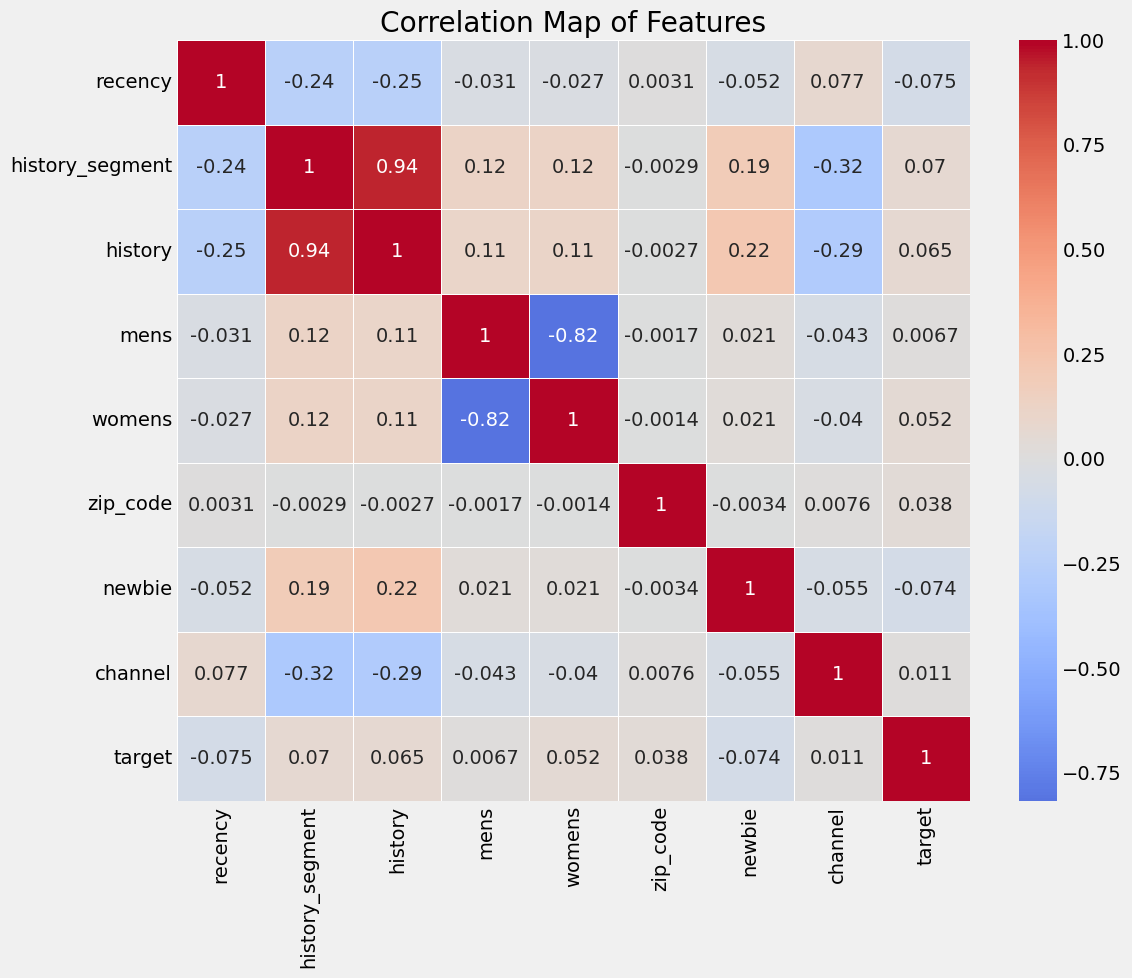

Top 10 strongest correlations:


history_segment  history            0.938582
mens             womens             0.816943
history_segment  channel            0.318429
history          channel            0.290378
recency          history            0.246591
                 history_segment    0.243782
history          newbie             0.223279
history_segment  newbie             0.187939
                 mens               0.120325
                 womens             0.120221
dtype: float64

All correlations with target:


history_segment    0.069734
history            0.065153
womens             0.051999
zip_code           0.037570
channel            0.010584
mens               0.006712
newbie            -0.073924
recency           -0.074765
Name: target, dtype: float64

In [11]:
corr_matrix = plot_correlation_heatmap(df, save_path=RESULTS_DIR / 'correlation_heatmap.png')

Анализ корреляций показывает, что среди признаков сильные взаимосвязи наблюдаются между history_segment и history (0,94), а также между mens и womens (0,82), что указывает на высокую степень пересечения этих переменных. Другие переменные демонстрируют слабую или умеренную взаимосвязь между собой.

Стоит отметить, что высокие корреляции между некоторыми признаками могут указывать на проблему мультиколлинеарности, что следует учитывать при выборе модели (возможно ухудшение качества результатов линейных моделей) и при интерпретации результатов feature importances tree-based моделей.

При этом корреляции всех признаков с целевой переменной target остаются низкими: наибольшая положительная корреляция у history_segment (0,07) и history (0,065), а наибольшие отрицательные — у recency (-0,075) и newbie (-0,074). Это говорит о том, что ни один отдельный признак не оказывает сильного влияния на целевую метрику, и для предсказания target потребуется использование сочетания нескольких признаков или более сложных моделей.

Заключение:

После этапа предобработки данные достаточно чистые и достаточно объёмные для проведения uplift-моделирования. В качестве базовой  модели следует выбирать модель градиентного бустинга и uplift модели, учитывающие несбалансированность данных (TLearner, XLearner).

## Train/test data split

In [12]:
df = df.astype({
    'history_segment': 'category', 
    'mens': 'bool',
    'womens': 'bool',
    'zip_code': 'category',
    'newbie': 'bool',
    'channel': 'category',
    'treatment': 'bool', 
    'target': 'bool'
})

categorical_features = [
    'history_segment', 
    'mens', 
    'womens', 
    'zip_code', 
    'newbie', 
    'channel'
]

categorical_indices = [df.columns.get_loc(col) for col in categorical_features]

In [13]:
X = df.drop(['target'], axis=1)
y = df['target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, 
                                        test_size=0.2, 
                                        stratify=df[['target', 'treatment']],
                                        random_state=42
                                        )

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 51200 samples
Test set: 12800 samples


## Modelling

### Baseline model

Baseline model saved to: models/baseline_catboost_model.cbm
Baseline metrics saved to: results/metrics_baseline_model.json
Uplift AUC: 0.03
Qini AUC: 0.06
Uplift@30: 0.0426
Uplift curve saved to: results/baseline_uplift_curve.png


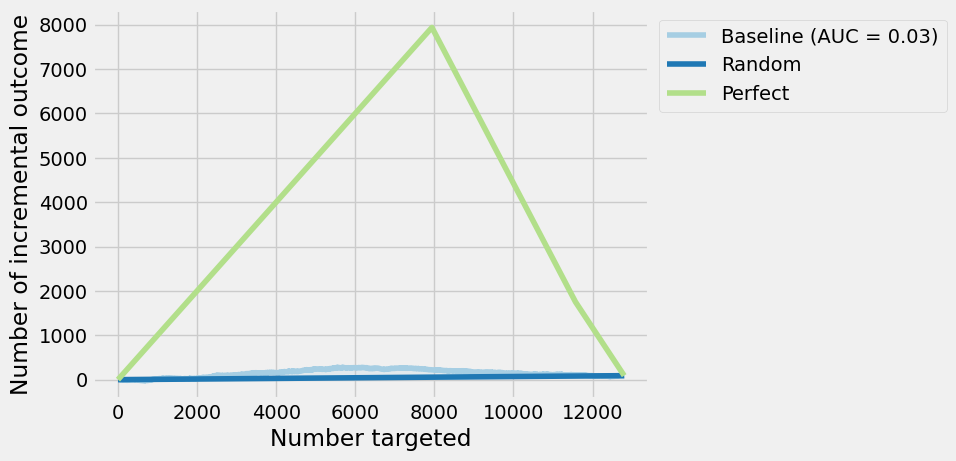

Qini curve saved to: results/baseline_qini_curve.png


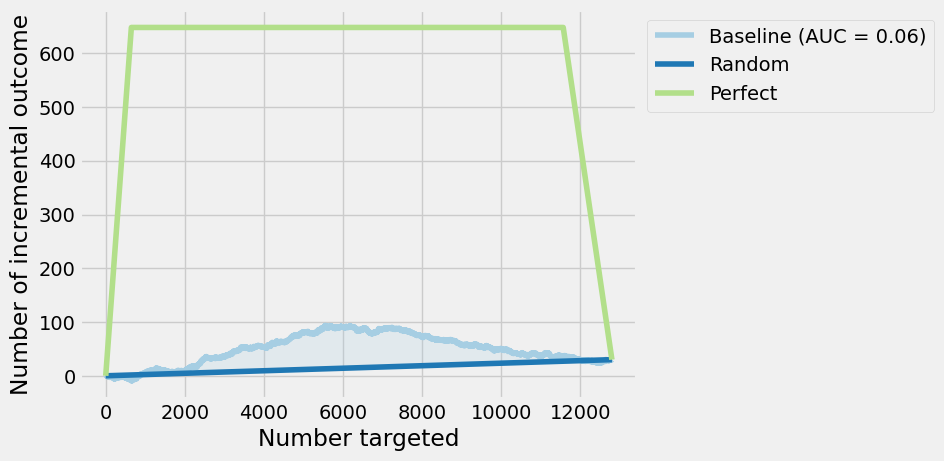

In [15]:
# ---------- Baseline model ---------- #
baseline_model = CatBoostClassifier(
                    cat_features=categorical_features,
                    iterations=500, 
                    depth=6, 
                    learning_rate=0.1,
                    auto_class_weights='Balanced', 
                    random_seed=42, 
                    verbose=0
                    )

baseline_model.fit(X_train, y_train)
all_params_baseline_model = baseline_model.get_all_params()

# ---------- Save baseline model ---------- #
baseline_model_path = MODELS_DIR / 'baseline_catboost_model.cbm'
baseline_model.save_model(str(baseline_model_path))
print(f"Baseline model saved to: {baseline_model_path}")

# ---------- Estimate uplift for each user ---------- #
# Create copies of test data
X_test_treated = X_test.copy()
X_test_control = X_test.copy()

# Set treatment value
X_test_treated['treatment'] = 1  # With treatment
X_test_control['treatment'] = 0  # Without treatment

# Predict results for both cases
y_pred_treated = baseline_model.predict_proba(X_test_treated)[:,1]
y_pred_control = baseline_model.predict_proba(X_test_control)[:,1]

# Calculate uplift as difference between predictions
uplift_pred_baseline = y_pred_treated - y_pred_control

# Add predicted uplift to test data for analysis
X_test_predicted = X_test.copy()
X_test_predicted['predicted_uplift'] = uplift_pred_baseline

# Calculate uplift metrics
uplift_score = uplift_auc_score(
    y_test.values, 
    X_test_predicted['predicted_uplift'], 
    X_test['treatment'].values
)
qini_score = qini_auc_score(
    y_test.values, 
    X_test_predicted['predicted_uplift'],  
    X_test['treatment'].values
)
uplift_30 = uplift_at_k(
    y_test.values, 
    X_test_predicted['predicted_uplift'],  
    X_test['treatment'].values,
    strategy='overall',
    k=0.3
)

metrics_baseline = {
        'model': 'baseline_catboost',
        'uplift_auc': float(uplift_score), 
        'qini_auc': float(qini_score), 
        'uplift_at_30': float(uplift_30)
    }

# Save metrics locally
metrics_baseline_path = RESULTS_DIR / 'metrics_baseline_model.json'
with metrics_baseline_path.open('w') as f:
    json.dump(metrics_baseline, f, indent=2)
print(f"Baseline metrics saved to: {metrics_baseline_path}")

print(f"Uplift AUC: {uplift_score:.2f}")
print(f"Qini AUC: {qini_score:.2f}")
print(f"Uplift@30: {uplift_30:.4f}")

# Plot and save uplift curve
fig_uplift = plot_uplift_curve(y_test,
    uplift_pred_baseline,
    X_test['treatment'].values, name='Baseline')
plt.savefig(RESULTS_DIR / 'baseline_uplift_curve.png', dpi=150, bbox_inches='tight')
print(f"Uplift curve saved to: {RESULTS_DIR / 'baseline_uplift_curve.png'}")
plt.show()

# Plot and save Qini curve
fig_qini = plot_qini_curve(y_test,
    uplift_pred_baseline, 
    X_test['treatment'].values, name='Baseline')
plt.savefig(RESULTS_DIR / 'baseline_qini_curve.png', dpi=150, bbox_inches='tight')
print(f"Qini curve saved to: {RESULTS_DIR / 'baseline_qini_curve.png'}")
plt.show()

In [16]:
# ---------- Extract feature importances ---------- #
importances = baseline_model.get_feature_importance(type="PredictionValuesChange")
feature_names = baseline_model.feature_names_

catboost_feature_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

display(catboost_feature_importances)

,feature,importance
2,history,29.817504
0,recency,16.728142
5,zip_code,11.862450
7,channel,9.721410
6,newbie,9.698603
1,history_segment,7.277675
4,womens,5.742920
3,mens,4.880735
8,treatment,4.270559


In [17]:
# ---------- Mlflow logging ---------- #
EXPERIMENT_NAME = 'uplift_modeling'

run_name_baseline = 'baseline_catboost'
registry_model_name_baseline = 'baseline_catboost'

log_to_mlflow(
        EXPERIMENT_NAME,
        run_name_baseline,
        registry_model_name_baseline,
        X_train=X_train, 
        model=baseline_model, 
        all_params=all_params_baseline_model, 
        metrics=metrics_baseline, 
        feature_importances_path=None
    )

/home/mle-user/mle_projects/mle-project-sprint-5/.uplift-venv/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/26 20:18:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'baseline_catboost' already exists. Creating a new version of this model.

🏃 View run baseline_catboost at: http://127.0.0.1:5000/#/experiments/21/runs/336216e89e184d0abf5dcccf5e40c8e5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/21
MLFlow logging done for baseline_catboost


Модель CatBoostClassifier показала небольшой, но положительный uplift:
- Uplift AUC 0.03
UPlift AUC измеряет, насколько хорошо модель различает пользователей, которые реагируют положительно на treatment, и тех, кто не реагирует. Полученное значение означает, что модель выявляет некоторый эффект uplift, но разделение между откликнувшимися и неоткликнувшимися слабое.
-  Qini AUC 0.06
Qini AUC сравнивает кумулятивный прирост конверсии при treatment пользователей согласно модели и случайном таргетировании. Полученное значение говорит о том, что модель немного лучше случайного таргетирования.
-  Uplift@30 0.0426
Измеряет ожидаемый прирост конверсии при treatment топ-30% пользователей, ранжированных по предсказанному uplift, эта метрика показывает практический бизнес-эффект применения модели. Полученное значение означает, что если применить treatment к топ-30% пользователей согласно модели, можно ожидать около 4,26% абсолютного прироста конверсии по сравнению с отсутствием treatment или случайным применением treatment.

Все три метрики показывают, что модель способна выявлять сегменты аудитории, где treatment повышает target, хотя общий эффект умеренный, что в свою очередь может быть обьяснимо выявленным на этапе EDA небольшим приростом среднего target после treatment (общий эффект treatment составляет всего 0,7 процентных пункта (относительное улучшение 5% с 14,4%в контрольной группе до 15,1% в тестовой группе)).

Анализ важности признаков показывает, что ключевыми факторами, влияющими на target, являются history (29.8%), recency (16.7%), zip_code (11.9%), при этом признак treatment имеет относительно небольшое влияние (4.27%) на target.

Для улучшения результатов моделирования эффекта можно рассмотреть альтернативные методы uplift-моделирования, добавление новых признаков и подбор гиперпараметров модели.

### T-Learner

In [18]:
# ---------- T-Learner ---------- #
class TLearner: 
    '''
        T-Learner uplift modelling with separate treatment and control models
    '''
    
    def __init__(self):
        '''
            Initialize models
        '''

        # CatBoostClassifier for treatment learners
        treatment_cb_clf = CatBoostClassifier(
                            iterations=500, 
                            depth=6, 
                            learning_rate=0.1,
                            auto_class_weights='Balanced', 
                            random_seed=42, 
                            verbose=0
                            )

        # CatBoostClassifier for control learner
        control_cb_clf = CatBoostClassifier(
                            iterations=500, 
                            depth=6, 
                            learning_rate=0.1,
                            auto_class_weights='Balanced', 
                            random_seed=42, 
                            verbose=0
                            )

        self.treatment_learner = treatment_cb_clf
        self.control_learner = control_cb_clf

    def fit(self, X_train, y_train, treatment):

        # Initialize T-learner with separate treatment and control models
        self.t_learner = BaseTClassifier(
            treatment_learner=self.treatment_learner,
            control_learner=self.control_learner,
            control_name=0
        )

        # Fit T-learner
        self.t_learner.fit(
            X=X_train.drop('treatment', axis=1).values,               
            treatment=X_train['treatment'].values,       
            y=y_train.astype(int).values
        )
    
    def save_model(self, path):
        '''
            Save T-Learner model to disk
        '''
        joblib.dump(self, path)
        print(f"T-Learner model saved to: {path}")
    
    def predict(self, X_test):
        '''
            Predict uplift for test set
        '''

        self.uplift_pred_t = self.t_learner.predict(X_test.drop('treatment', axis=1).values)
        return self.uplift_pred_t

    def evaluate(self, y_test, X_test, save_results=True):
        '''
            Evaluate T-learner performance
        '''

        # Calculate uplift metrics
        uplift_score = uplift_auc_score(
                            y_test.astype(int).values,
                            self.uplift_pred_t.squeeze(),
                            X_test['treatment'].values
                        )
        print(f"Uplift AUC: {uplift_score:.2f}")

        # Calculate Qini AUC
        qini_score = qini_auc_score(
                        y_test.astype(int).values,
                        self.uplift_pred_t.squeeze(),
                        X_test['treatment'].values
                    )
        print(f"Qini AUC: {qini_score:.2f}")

        # Calculate uplift@30%
        uplift_30 = uplift_at_k(
                        y_test.astype(int).values,
                        self.uplift_pred_t.squeeze(),
                        X_test['treatment'].values,
                        strategy='overall',
                        k=0.3
                    )
        print(f"Uplift@30: {uplift_30:.4f}")

        metrics_t_learner = {
            'model': 't_learner',
            'uplift_auc': float(uplift_score),
            'qini_auc': float(qini_score),
            'uplift_at_30': float(uplift_30)
        }

        if save_results:
            # Save metrics locally
            metrics_path = RESULTS_DIR / 'metrics_t_learner.json'
            with metrics_path.open('w') as f:
                json.dump(metrics_t_learner, f, indent=2)
            print(f"T-Learner metrics saved to: {metrics_path}")

            # Plot and save uplift curve
            plot_uplift_curve(
                y_test.astype(int).values,
                self.uplift_pred_t.squeeze(),
                X_test['treatment'].values, 
                name='T-Learner'
                )
            plt.savefig(RESULTS_DIR / 't_learner_uplift_curve.png', dpi=150, bbox_inches='tight')
            print(f"Uplift curve saved to: {RESULTS_DIR / 't_learner_uplift_curve.png'}")
            plt.show()

            # Plot and save Qini curve
            plot_qini_curve(
                y_test.astype(int).values,
                self.uplift_pred_t.squeeze(), 
                X_test['treatment'].values, 
                name='T-Learner'
                )
            plt.savefig(RESULTS_DIR / 't_learner_qini_curve.png', dpi=150, bbox_inches='tight')
            print(f"Qini curve saved to: {RESULTS_DIR / 't_learner_qini_curve.png'}")
            plt.show()
        else:
            # Just plot without saving
            plot_uplift_curve(
                y_test.astype(int).values,
                self.uplift_pred_t.squeeze(),
                X_test['treatment'].values, 
                name='T-Learner'
                )
            plt.show()

            plot_qini_curve(
                y_test.astype(int).values,
                self.uplift_pred_t.squeeze(), 
                X_test['treatment'].values, 
                name='T-Learner'
                )
            plt.show()

        return uplift_score, qini_score, uplift_30, metrics_t_learner


Uplift AUC: 0.01
Qini AUC: 0.03
Uplift@30: 0.0272
T-Learner metrics saved to: results/metrics_t_learner.json
Uplift curve saved to: results/t_learner_uplift_curve.png


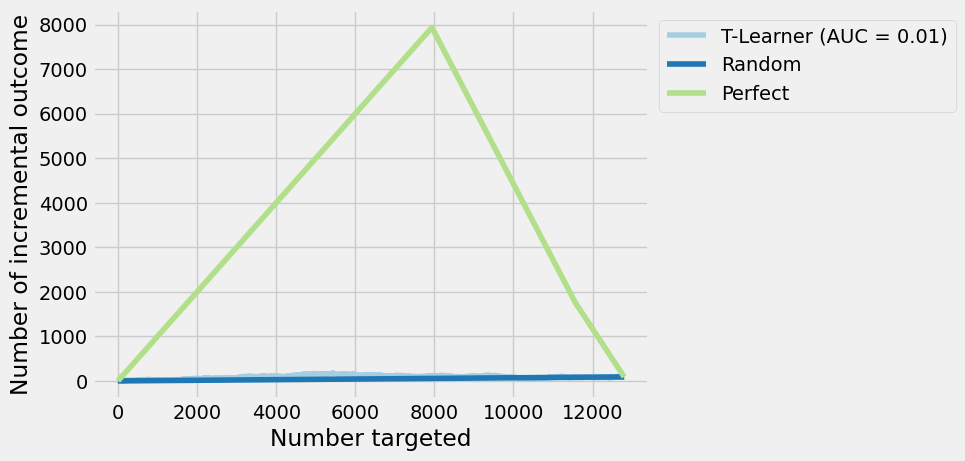

Qini curve saved to: results/t_learner_qini_curve.png


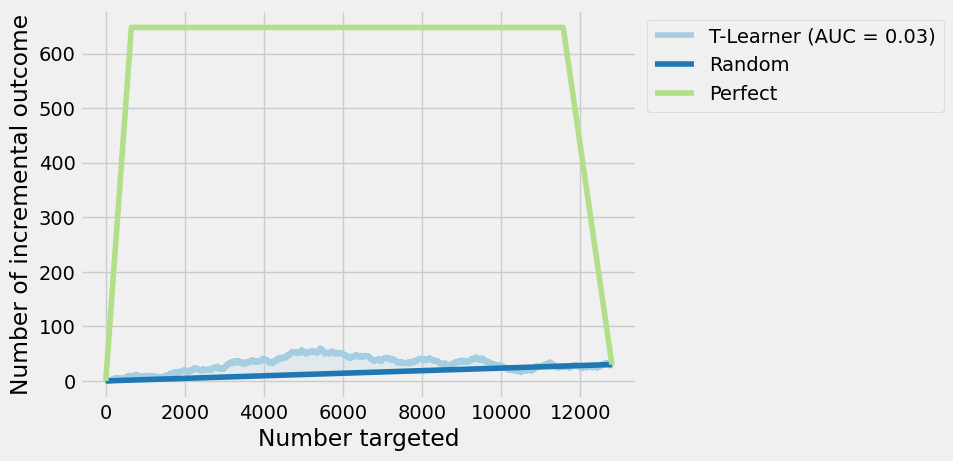

T-Learner model saved to: models/t_learner_model.joblib


In [19]:
t_learner = TLearner()
t_learner.fit(X_train, y_train, X_train['treatment'])
t_learner.predict(X_test)
uplift_score_t, qini_score_t, uplift_30_t, metrics_t_learner = t_learner.evaluate(y_test, X_test, save_results=True)

# Define params for logging (from TLearner class)
all_params_t_learner = {
    'iterations': 500,
    'depth': 6,
    'learning_rate': 0.1,
    'auto_class_weights': 'Balanced',
    'random_seed': 42
}

# Save T-Learner model
t_learner.save_model(MODELS_DIR / 't_learner_model.joblib')

In [20]:
# ---------- Mlflow logging ---------- #
run_name_t_learner = 'tlearner'
registry_model_name_t_learner = 'tlearner'

log_to_mlflow(
        EXPERIMENT_NAME,
        run_name_t_learner,
        registry_model_name_t_learner,
        X_train=X_train, 
        model=t_learner, 
        all_params=all_params_t_learner, 
        metrics=metrics_t_learner, 
        feature_importances_path=None
    )

/home/mle-user/mle_projects/mle-project-sprint-5/.uplift-venv/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/26 20:18:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'tlearner' already exists. Creating a new version of this model...
2025/1

🏃 View run tlearner at: http://127.0.0.1:5000/#/experiments/21/runs/a1f86f3769b7429ca92e5f3781686d65
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/21
MLFlow logging done for tlearner


### X-learner

In [21]:
# ---------- X-Learner ---------- #
class XLearner:
    '''
        X-learner with propensity score computation
    '''
    
    def __init__(self, params_clf, params_rgs, control_name):
        '''
            Initialize models
        '''

        # CatBoostClassifier for outcome-models
        # No cat_features as causalml converts data to numpy arrays internally (no column names)
        cb_clf = CatBoostClassifier(**params_clf)

        # CatBoostRegressor for effect-models
        # No cat_features as causalml converts data to numpy arrays internally (no column names)
        cb_rgs = CatBoostRegressor(**params_rgs)
        
        self.outcome_learner = cb_clf
        self.control_name = control_name
        self.effect_learner = cb_rgs
        self.propensity_train = None
        self.propensity_test = None
        self.propensity_model = None  # Store the propensity model for inference
        self.params_clf = params_clf
        self.params_rgs = params_rgs

    def compute_propensity_scores(self, X_train, X_test, propensity_params=None):
        '''
            Compute propensity scores for train and test sets.
        '''

        if propensity_params is None:
            propensity_params = {
                'random_state': 42,
                'n_estimators': 200,
                'max_depth': 10,
                'learning_rate': 0.1,
                'use_label_encoder': False,
                'eval_metric': 'logloss',
                'n_jobs': -1,
                'verbosity': 0
            }
        
        self.propensity_model = XGBClassifier(**propensity_params)
               
        self.propensity_model.fit(
            X_train.drop('treatment', axis=1).values, 
            X_train['treatment'].values
            )
        
        # Get propensity scores
        self.propensity_train = self.propensity_model.predict_proba(X_train.drop('treatment', axis=1).values)[:, 1]
        self.propensity_test = self.propensity_model.predict_proba(X_test.drop('treatment', axis=1).values)[:, 1]
        
        return self.propensity_train, self.propensity_test

    def fit(self, X_train, X_test, y_train, y_test, treatment):  
        '''
            Fit X-learner
        '''

        # Initialize X-learner
        self.x_learner = BaseXClassifier(
                        outcome_learner=self.outcome_learner,
                        control_name=self.control_name,
                        effect_learner=self.effect_learner,
                    )

        # Fit X-learner with propensity score
        self.x_learner.fit(
            X=X_train.drop('treatment', axis=1).values,
            treatment=X_train['treatment'].values,
            y=y_train.astype(int).values,
            p=self.propensity_train
        )

    def save_model(self, path):
        '''
            Save X-Learner model to disk
        '''
        joblib.dump(self, path)
        print(f"X-Learner model saved to: {path}")

    def predict(self, X):
        '''
            Predict uplift for any dataset.
            Computes propensity scores dynamically using the stored propensity model.
        '''
        # Handle both DataFrames with 'treatment' column and without
        if hasattr(X, 'columns') and 'treatment' in X.columns:
            X_features = X.drop('treatment', axis=1).values
        elif hasattr(X, 'values'):
            X_features = X.values
        else:
            X_features = X
        
        # Compute propensity scores dynamically using the stored model
        propensity_scores = self.propensity_model.predict_proba(X_features)[:, 1]
        
        self.uplift_pred_x = self.x_learner.predict(
            X=X_features,
            p=propensity_scores
        )
        return self.uplift_pred_x
    
    def evaluate(self, y_test, X_test, experiment, save_results=True):
        '''
            X-learner performance evaluation
        '''

        # Calculate uplift metrics
        uplift_score = uplift_auc_score(
                            y_test.astype(int).values,
                            self.uplift_pred_x.squeeze(),
                            X_test['treatment'].values
                        )
        print(f"Uplift AUC: {uplift_score:.2f}")

        # Calculate Qini AUC
        qini_score = qini_auc_score(
                        y_test.astype(int).values,
                        self.uplift_pred_x.squeeze(),
                        X_test['treatment'].values
                    )
        print(f"Qini AUC: {qini_score:.2f}")

        # Calculate uplift@30%
        uplift_30 = uplift_at_k(
                        y_test.astype(int).values,
                        self.uplift_pred_x.squeeze(),
                        X_test['treatment'].values,
                        strategy='overall',
                        k=0.3
                    )
        print(f"Uplift@30: {uplift_30:.4f}")

        metrics_x_learner = {
            'model': f'x_learner_{experiment}',
            'uplift_auc': float(uplift_score),
            'qini_auc': float(qini_score),
            'uplift_at_30': float(uplift_30),
            'params_clf': self.params_clf,
            'params_rgs': self.params_rgs
        }

        if save_results:
            # Save metrics locally
            metrics_path = RESULTS_DIR / f'metrics_x_learner_{experiment}.json'
            with metrics_path.open('w') as f:
                json.dump(metrics_x_learner, f, indent=2)
            print(f"X-Learner metrics saved to: {metrics_path}")

            # Plot and save uplift curve
            plot_uplift_curve(
                y_test.astype(int).values,
                self.uplift_pred_x.squeeze(),
                X_test['treatment'].values, 
                name=f'X-Learner ({experiment})'
                )
            plt.savefig(RESULTS_DIR / f'x_learner_{experiment}_uplift_curve.png', dpi=150, bbox_inches='tight')
            print(f"Uplift curve saved to: {RESULTS_DIR / f'x_learner_{experiment}_uplift_curve.png'}")
            plt.show()

            # Plot and save Qini curve
            plot_qini_curve(
                y_test.astype(int).values,
                self.uplift_pred_x.squeeze(), 
                X_test['treatment'].values, 
                name=f'X-Learner ({experiment})'
                )
            plt.savefig(RESULTS_DIR / f'x_learner_{experiment}_qini_curve.png', dpi=150, bbox_inches='tight')
            print(f"Qini curve saved to: {RESULTS_DIR / f'x_learner_{experiment}_qini_curve.png'}")
            plt.show()
        else:
            # Just plot without saving
            plot_uplift_curve(
                y_test.astype(int).values,
                self.uplift_pred_x.squeeze(),
                X_test['treatment'].values, 
                name=f'X-Learner ({experiment})'
                )
            plt.show()

            plot_qini_curve(
                y_test.astype(int).values,
                self.uplift_pred_x.squeeze(), 
                X_test['treatment'].values, 
                name=f'X-Learner ({experiment})'
                )
            plt.show()

        return uplift_score, qini_score, uplift_30, metrics_x_learner


Uplift AUC: 0.01
Qini AUC: 0.03
Uplift@30: 0.0329
X-Learner metrics saved to: results/metrics_x_learner_initial.json
Uplift curve saved to: results/x_learner_initial_uplift_curve.png


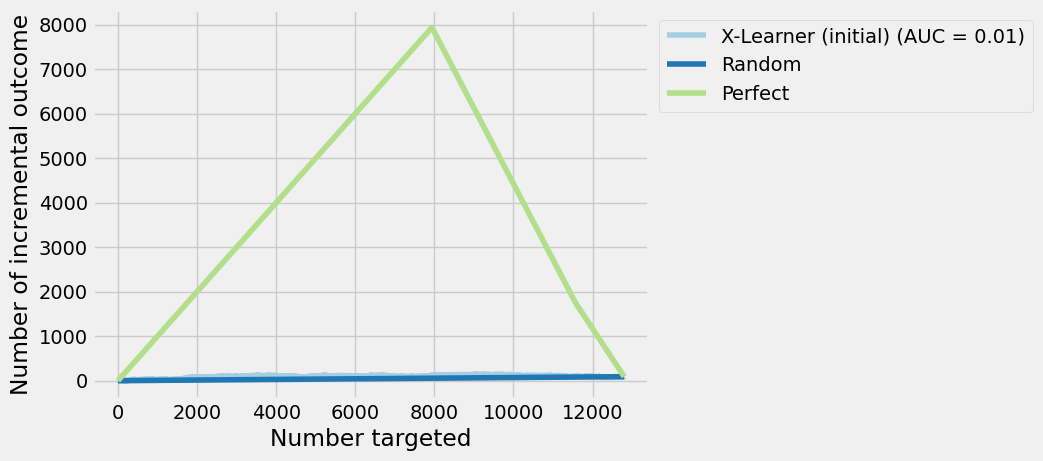

Qini curve saved to: results/x_learner_initial_qini_curve.png


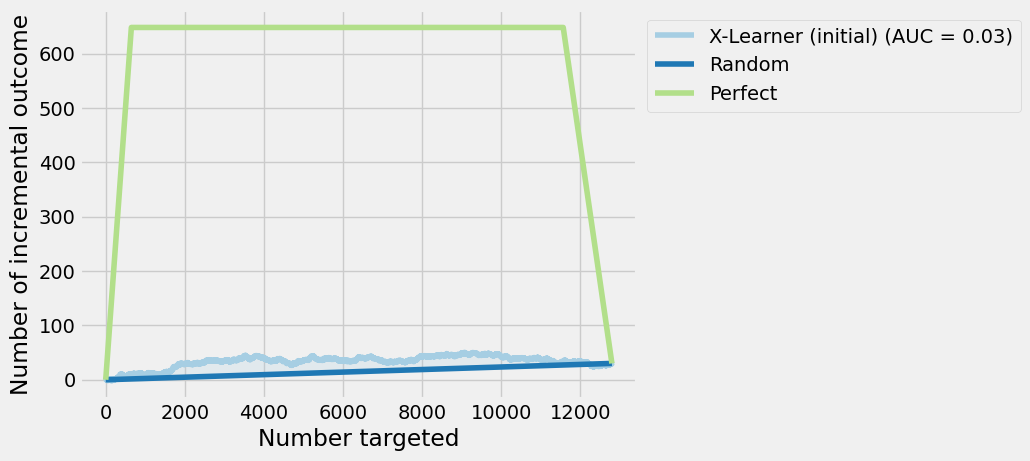

X-Learner model saved to: models/x_learner_initial_model.joblib


In [22]:
params_clf = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
params_rgs = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}

x_learner = XLearner(params_clf, params_rgs, control_name=0)
x_learner.compute_propensity_scores(X_train, X_test)
x_learner.fit(X_train, X_test, y_train, y_test, X_train['treatment'])
x_learner.predict(X_test)
uplift_score_x, qini_score_x, uplift_30_x, metrics_x_learner = x_learner.evaluate(y_test, X_test, 'initial', save_results=True)

# Define combined params for logging
all_params_x_learner = {
    'clf_iterations': params_clf['iterations'],
    'clf_depth': params_clf['depth'],
    'clf_learning_rate': params_clf['learning_rate'],
    'rgs_iterations': params_rgs['iterations'],
    'rgs_depth': params_rgs['depth'],
    'rgs_learning_rate': params_rgs['learning_rate'],
    'random_seed': params_clf['random_seed']
}

# Save initial X-Learner model
x_learner.save_model(MODELS_DIR / 'x_learner_initial_model.joblib')

In [23]:
# ---------- Mlflow logging ---------- #
run_name_x_learner = 'xlearner_initial'
registry_model_name_x_learner = 'xlearner'

log_to_mlflow(
        EXPERIMENT_NAME,
        run_name_x_learner,
        registry_model_name_x_learner,
        X_train=X_train, 
        model=x_learner, 
        all_params=all_params_x_learner, 
        metrics=metrics_x_learner, 
        feature_importances_path=None
    )

/home/mle-user/mle_projects/mle-project-sprint-5/.uplift-venv/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/26 20:18:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'xlearner' already exists. Creating a new version of this model...
2025/1

🏃 View run xlearner_initial at: http://127.0.0.1:5000/#/experiments/21/runs/620314e69edc418da2020b50654c1c51
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/21
MLFlow logging done for xlearner_initial


Сравнение моделей uplift показывает, что Baseline CatBoostClassifier явно превосходит T-Learner и X-Learner по всем ключевым метрикам. 

CatBoost достигает наивысших значений Uplift AUC (0.03), Qini AUC (0.06) и Uplift@30 (0.0468), что свидетельствует о его лучшей способности ранжировать пользователей по ожидаемому эффекту treatment и обеспечивать измеримый прирост конверсии при таргетировании топ-30% пользователей. В то же время, T-Learner и X-Learner показывают значительно худшие результаты: Uplift AUC 0.01, Qini AUC от 0.01 до 0.02 и Uplift@30 около 2,7-3,3%, что отражает ограниченную практическую пользу и слабую способность выявлять отзывчивых пользователей. 

Более низкие результаты более сложных моделей могут быть связаны с тем, что:
- CatBoost обрабатывает категориальные признаки нативно, используя target encoding и другие техники. Большинство признаков в датасете являются категориальными и такие признаки, как zip_code, channel, history_segment, newbie, имеют важное значение для предсказаний. CatBoost позволяет извлекать значимые закономерности из таких переменных.
-  Mета-алгоритмы causalml T-Learner и X-Learner не умеют работать с категориальными признаками напрямую (невозможность использовать имена колонок для категориальных признаков в BaseTClassifier и BaseXClassifier не является ограничением CatBoost, а связана с тем, как мета-алгоритмы causalml преобразуют входные данные в numpy-массивы, что приводит к потере имен колонок). Признаки воспринимаются как числовые, что создаёт искусственные порядковые зависимости между категориями и снижает способность модели выявлять эффект treatment.

Для улучшения производительности T-Learner и X-Learner можно:
- Использовать корректное кодирование категориальных признаков, например one-hot или target encoding;
- Создать дополнительные информативные признаки или их взаимодействия;
- Оптимизировать гиперпараметры.

Перечисленные методы улучшения качества модели будут далее реализованы для модели X-Learner.

# Часть 2

## Selected model results improvement

### Encoding of categorical features

In [24]:
# ---------- One-hot encoding of categorical features ---------- #
def one_hot_encoding(df, cat_features):
    '''
        One-hot encoding of categorical features
    '''
    
    df_encoded = df.copy()

    for col in cat_features:
        df_encoded[col] = df_encoded[col].astype(str)

    df_encoded = pd.get_dummies(df_encoded, columns=cat_features, drop_first=True)
    
    return df_encoded

In [25]:
# One-hot encoding of categorical features of original dataset

cat_original_to_encode = [
    'history_segment', 
    'mens',
    'womens',
    'zip_code', 
    'newbie',
    'channel'
    ]

X_train_encoded = one_hot_encoding(X_train, cat_original_to_encode)
X_test_encoded = one_hot_encoding(X_test, cat_original_to_encode)

print(f"\nTrain set shape: {X_train_encoded.shape}")
print(f"Test set shape: {X_test_encoded.shape}")


Train set shape: (51200, 16)
Test set shape: (12800, 16)


Uplift AUC: 0.01
Qini AUC: 0.03
Uplift@30: 0.0312
X-Learner metrics saved to: results/metrics_x_learner_ohe.json
Uplift curve saved to: results/x_learner_ohe_uplift_curve.png


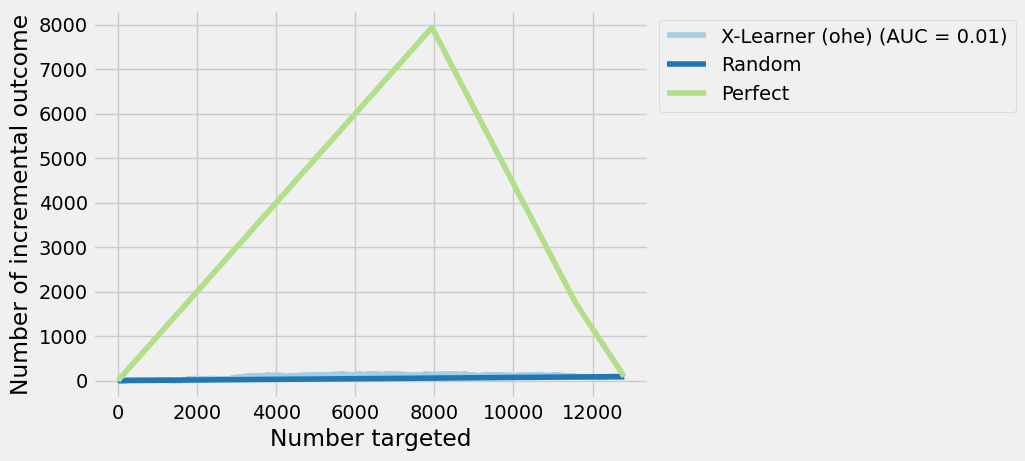

Qini curve saved to: results/x_learner_ohe_qini_curve.png


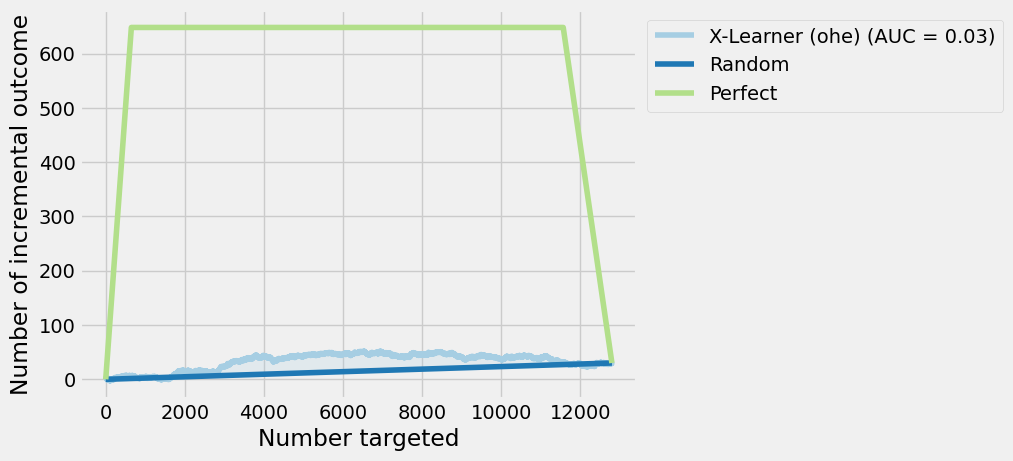

X-Learner model saved to: models/x_learner_ohe_model.joblib


In [26]:
# Retrain X-learner with one-hot encoded features
params_clf_ohe = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
params_rgs_ohe = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
x_learner_ohe = XLearner(params_clf_ohe, params_rgs_ohe, control_name=0)
x_learner_ohe.compute_propensity_scores(X_train_encoded, X_test_encoded)
x_learner_ohe.fit(
    X_train_encoded, 
    X_test_encoded, 
    y_train, 
    y_test, 
    X_train_encoded['treatment']
)
x_learner_ohe.predict(X_test_encoded)
_, _, _, metrics_x_learner_ohe = x_learner_ohe.evaluate(y_test, X_test_encoded, 'ohe', save_results=True)

# Define params for logging
all_params_x_learner_ohe = {
    'clf_iterations': params_clf_ohe['iterations'],
    'clf_depth': params_clf_ohe['depth'],
    'clf_learning_rate': params_clf_ohe['learning_rate'],
    'rgs_iterations': params_rgs_ohe['iterations'],
    'rgs_depth': params_rgs_ohe['depth'],
    'rgs_learning_rate': params_rgs_ohe['learning_rate'],
    'random_seed': params_clf_ohe['random_seed']
}

# Save X-Learner with one-hot encoding model
x_learner_ohe.save_model(MODELS_DIR / 'x_learner_ohe_model.joblib')

In [27]:
# ---------- Mlflow logging ---------- #
run_name_x_learner_ohe = 'xlearner_ohe'

log_to_mlflow(
        EXPERIMENT_NAME,
        run_name_x_learner_ohe,
        registry_model_name_x_learner,
        X_train=X_train_encoded, 
        model=x_learner_ohe, 
        all_params=all_params_x_learner_ohe, 
        metrics=metrics_x_learner_ohe, 
        feature_importances_path=None
    )

/home/mle-user/mle_projects/mle-project-sprint-5/.uplift-venv/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/26 20:18:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'xlearner' already exists. Creating a new version of this model...
2025/1

🏃 View run xlearner_ohe at: http://127.0.0.1:5000/#/experiments/21/runs/9847b391f76f42c2968395af80c0ba93
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/21
MLFlow logging done for xlearner_ohe


### Feature engineering

In [28]:
# ---------- Feature preprocessing and engineering ---------- #
def features_engineering(df):
    '''
        Create engineered features based on EDA insights:
        - history and history_segment are highly correlated
        - mens and womens are highly correlated
        - recency is second most important
        - zip_code and channel are important categoricals
    '''

    df_engineered = df.copy()
    
    # Interaction feature: history per recency (combines top 2 important features)
    df_engineered['history_per_recency'] = df_engineered['history'] / (df_engineered['recency'] + 1)
    
    # Log transform of history (reduces effect of right-skewness)
    df_engineered['log_history'] = np.log1p(df_engineered['history'])
    
    # Customer gender preference (reduces effect of multicollinearity between mens and womens)
    # 0 = neither, 1 = mens only, 2 = womens only, 3 = both
    df_engineered['gender_type'] = df_engineered['mens'].astype(int) + 2 * df_engineered['womens'].astype(int)
    
    # Recency bins (negative correlation with target)
    df_engineered['recency_bin'] = pd.cut(df_engineered['recency'], bins=[0, 3, 6, 9, 12], labels=[0, 1, 2, 3]).astype(int)
    
    # History bins (positive correlation with target)
    df_engineered['history_bin'] = pd.qcut(df_engineered['history'], q=4, labels=[0, 1, 2, 3], duplicates='drop').astype(int)
    
    # Newbie and recency interaction (both have negative correlation with target)
    df_engineered['newbie_recency'] = df_engineered['newbie'].astype(int) * df_engineered['recency']
    
    # High value customer flag (history > median)
    history_median = df_engineered['history'].median()
    df_engineered['high_value'] = (df_engineered['history'] > history_median).astype(int)
    
    return df_engineered

In [29]:
# Apply feature engineering to train and test sets
X_train_engineered = features_engineering(X_train)
X_test_engineered = features_engineering(X_test)

In [30]:
# One-hot encode categorical features of feature engineered dataset
cat_engineered_to_encode = [
    'history_segment', 
    'zip_code', 
    'channel', 
    'gender_type', 
    'recency_bin', 
    'history_bin'
    ]

X_train_engineered_encoded = one_hot_encoding(X_train_engineered, cat_engineered_to_encode)
X_test_engineered_encoded = one_hot_encoding(X_test_engineered, cat_engineered_to_encode)

print('New feature columns:')
print([col for col in X_train_engineered_encoded.columns if col not in X_train.columns][:20])
print('Train set shape: {X_train_engineered_encoded.shape}')
print('Test set shape: {X_test_engineered_encoded.shape}')

New feature columns:
['history_per_recency', 'log_history', 'newbie_recency', 'high_value', 'history_segment_1', 'history_segment_2', 'history_segment_3', 'history_segment_4', 'history_segment_5', 'history_segment_6', 'zip_code_1', 'zip_code_2', 'channel_1', 'channel_2', 'gender_type_2', 'gender_type_3', 'recency_bin_1', 'recency_bin_2', 'recency_bin_3', 'history_bin_1']
Train set shape: {X_train_engineered_encoded.shape}
Test set shape: {X_test_engineered_encoded.shape}


Uplift AUC: 0.02
Qini AUC: 0.04
Uplift@30: 0.0298
X-Learner metrics saved to: results/metrics_x_learner_fe_ohe.json
Uplift curve saved to: results/x_learner_fe_ohe_uplift_curve.png


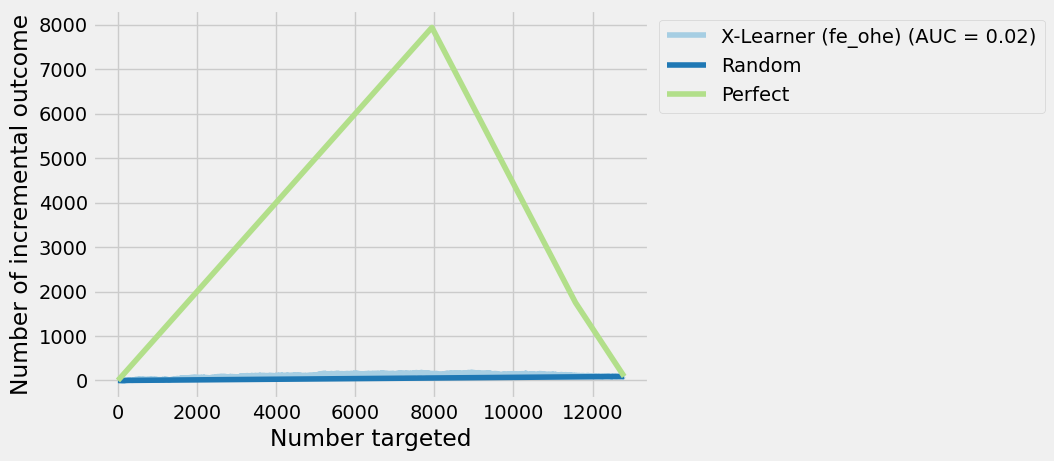

Qini curve saved to: results/x_learner_fe_ohe_qini_curve.png


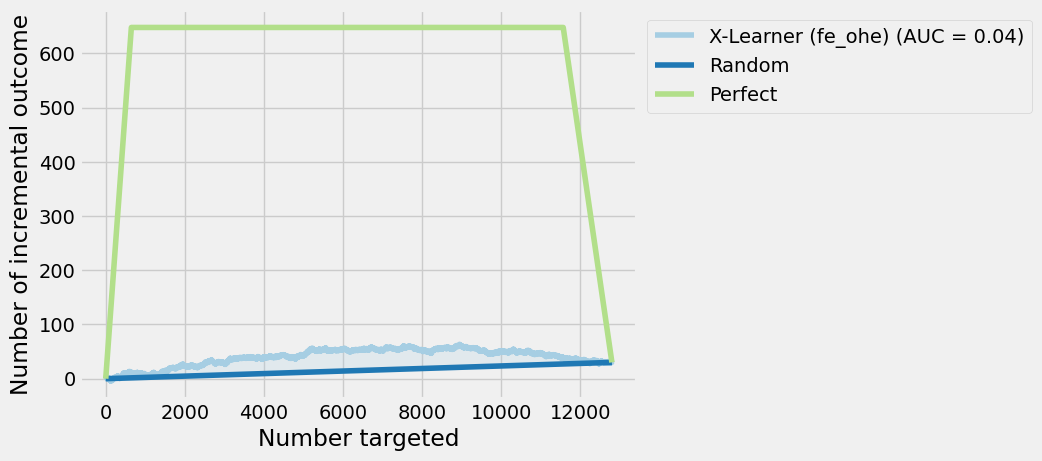

X-Learner model saved to: models/x_learner_fe_ohe_model.joblib


In [31]:
# Retrain X-learner with engineered and one-hot encoded features
params_clf_fe = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
params_rgs_fe = {
    'iterations': 500, 
    'depth': 6, 
    'learning_rate': 0.1,
    'random_seed': 42, 
    'verbose': 0
}
x_learner_fe = XLearner(params_clf_fe, params_rgs_fe, control_name=0)
x_learner_fe.compute_propensity_scores(X_train_engineered_encoded, X_test_engineered_encoded)
x_learner_fe.fit(
    X_train_engineered_encoded, 
    X_test_engineered_encoded, 
    y_train, 
    y_test, 
    X_train_engineered_encoded['treatment']
)
x_learner_fe.predict(X_test_engineered_encoded)
_, _, _, metrics_x_learner_fe = x_learner_fe.evaluate(y_test, X_test_engineered_encoded, 'fe_ohe', save_results=True)

# Define params for logging
all_params_x_learner_fe = {
    'clf_iterations': params_clf_fe['iterations'],
    'clf_depth': params_clf_fe['depth'],
    'clf_learning_rate': params_clf_fe['learning_rate'],
    'rgs_iterations': params_rgs_fe['iterations'],
    'rgs_depth': params_rgs_fe['depth'],
    'rgs_learning_rate': params_rgs_fe['learning_rate'],
    'random_seed': params_clf_fe['random_seed']
}

# Save X-Learner with feature engineering model
x_learner_fe.save_model(MODELS_DIR / 'x_learner_fe_ohe_model.joblib')

In [32]:
# ---------- Mlflow logging ---------- #
run_name_x_learner_fe = 'xlearner_fe'

log_to_mlflow(
        EXPERIMENT_NAME,
        run_name_x_learner_fe,
        registry_model_name_x_learner,
        X_train=X_train_engineered_encoded, 
        model=x_learner_fe, 
        all_params=all_params_x_learner_fe, 
        metrics=metrics_x_learner_fe, 
        feature_importances_path=None
    )

/home/mle-user/mle_projects/mle-project-sprint-5/.uplift-venv/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/26 20:19:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'xlearner' already exists. Creating a new version of this model...
2025/1

🏃 View run xlearner_fe at: http://127.0.0.1:5000/#/experiments/21/runs/f61c4911a06948b8981054f45853db91
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/21
MLFlow logging done for xlearner_fe


### Hyperparameters optimization

In [33]:
# Compute propensity scores for Optuna optimization using XLearner static method
x_learner = XLearner(params_clf, params_rgs, control_name=0)
propensity_train, propensity_test = x_learner.compute_propensity_scores(X_train_engineered_encoded, X_test_engineered_encoded)

In [34]:
# ---------- Hyperparameters tuning using Optuna ---------- #
def objective(trial, propensity_train, propensity_test):
    '''
        Objective function for Optuna
    '''
    
    # Hyperparameters to tune for CatBoostClassifier (prefixed with clf_)
    params_clf = {
        'iterations': trial.suggest_int('clf_iterations', 100, 1000),
        'depth': trial.suggest_int('clf_depth', 4, 10),
        'learning_rate': trial.suggest_float('clf_learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('clf_l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_seed': 42,
        'verbose': 0,
        'auto_class_weights': 'Balanced'
    }

    # Hyperparameters to tune for CatBoostRegressor (prefixed with rgs_)
    params_rgs = {
        'iterations': trial.suggest_int('rgs_iterations', 100, 1000),
        'depth': trial.suggest_int('rgs_depth', 4, 10),
        'learning_rate': trial.suggest_float('rgs_learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('rgs_l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_seed': 42,
        'verbose': 0,
    }
    
    # Create CatBoost models with trial parameters
    cb_clf = CatBoostClassifier(**params_clf)
    cb_rgs = CatBoostRegressor(**params_rgs)
    
    # Train X-Learner with tuned CatBoost
    x_learner_trial = BaseXClassifier(
        outcome_learner=cb_clf, 
        control_name=0,
        effect_learner=cb_rgs
    )
    
    x_learner_trial.fit(
        X=X_train_engineered_encoded.values,
        treatment=X_train_engineered_encoded['treatment'].values,
        y=y_train.astype(int).values,
        p=propensity_train
    )
    
    # Predict uplift
    uplift_pred = x_learner_trial.predict(
        X_test_engineered_encoded.values.copy(), 
        p=propensity_test
        ).squeeze()
    
    # Calculate uplift@30%
    uplift_at_30 = uplift_at_k(
        y_test.astype(int).values, 
        uplift_pred, 
        X_test_engineered_encoded['treatment'].values, 
        k=0.3, 
        strategy='overall'
    )

    return uplift_at_30

# Create and run the study with lambda to pass additional arguments
study = optuna.create_study(direction='maximize')
study.optimize(
    lambda trial: objective(trial, propensity_train, propensity_test), 
    n_trials=50, 
    show_progress_bar=True
)

# Print best hyperparameters
print(f"Best hyperparameters: {study.best_params}")
print(f"Best score: {study.best_value}")

[I 2025-12-26 20:19:13,312] A new study created in memory with name: no-name-260cb002-3b31-4d46-9439-182445ddc688
Best trial: 0. Best value: 0.0253246:   2%|▏         | 1/50 [00:34<27:59, 34.27s/it]

[I 2025-12-26 20:19:47,581] Trial 0 finished with value: 0.025324631635605194 and parameters: {'clf_iterations': 683, 'clf_depth': 9, 'clf_learning_rate': 0.010820298707754777, 'clf_l2_leaf_reg': 0.03308099492476369, 'rgs_iterations': 979, 'rgs_depth': 8, 'rgs_learning_rate': 0.22667083878608224, 'rgs_l2_leaf_reg': 0.005366731995982287}. Best is trial 0 with value: 0.025324631635605194.


Best trial: 1. Best value: 0.026401:   4%|▍         | 2/50 [01:11<28:59, 36.23s/it] 

[I 2025-12-26 20:20:25,187] Trial 1 finished with value: 0.026400955160140627 and parameters: {'clf_iterations': 770, 'clf_depth': 9, 'clf_learning_rate': 0.112363430389338, 'clf_l2_leaf_reg': 2.6554614516601656, 'rgs_iterations': 325, 'rgs_depth': 10, 'rgs_learning_rate': 0.03982992185808834, 'rgs_l2_leaf_reg': 0.022608972014226077}. Best is trial 1 with value: 0.026400955160140627.


Best trial: 2. Best value: 0.031499:   6%|▌         | 3/50 [01:30<21:55, 27.98s/it]

[I 2025-12-26 20:20:43,349] Trial 2 finished with value: 0.03149901643716868 and parameters: {'clf_iterations': 127, 'clf_depth': 9, 'clf_learning_rate': 0.2856636979317017, 'clf_l2_leaf_reg': 4.505612603168301, 'rgs_iterations': 567, 'rgs_depth': 9, 'rgs_learning_rate': 0.15895892158877245, 'rgs_l2_leaf_reg': 0.36633876720477776}. Best is trial 2 with value: 0.03149901643716868.


Best trial: 3. Best value: 0.040658:   8%|▊         | 4/50 [01:39<15:42, 20.48s/it]

[I 2025-12-26 20:20:52,334] Trial 3 finished with value: 0.040657982847851826 and parameters: {'clf_iterations': 409, 'clf_depth': 5, 'clf_learning_rate': 0.02799181321158164, 'clf_l2_leaf_reg': 0.10275641538485693, 'rgs_iterations': 665, 'rgs_depth': 6, 'rgs_learning_rate': 0.017931522751887658, 'rgs_l2_leaf_reg': 0.012369242332566371}. Best is trial 3 with value: 0.040657982847851826.


Best trial: 4. Best value: 0.0444607:  10%|█         | 5/50 [01:50<12:51, 17.15s/it]

[I 2025-12-26 20:21:03,564] Trial 4 finished with value: 0.04446069663460968 and parameters: {'clf_iterations': 743, 'clf_depth': 5, 'clf_learning_rate': 0.016564255737164194, 'clf_l2_leaf_reg': 1.3492256682330934, 'rgs_iterations': 180, 'rgs_depth': 9, 'rgs_learning_rate': 0.023003875570137274, 'rgs_l2_leaf_reg': 0.002023002739807417}. Best is trial 4 with value: 0.04446069663460968.


Best trial: 4. Best value: 0.0444607:  12%|█▏        | 6/50 [01:57<10:05, 13.76s/it]

[I 2025-12-26 20:21:10,746] Trial 5 finished with value: 0.023957327183168772 and parameters: {'clf_iterations': 328, 'clf_depth': 7, 'clf_learning_rate': 0.19262528837885914, 'clf_l2_leaf_reg': 0.1469575511706363, 'rgs_iterations': 240, 'rgs_depth': 5, 'rgs_learning_rate': 0.0837838581210455, 'rgs_l2_leaf_reg': 0.02637117236871102}. Best is trial 4 with value: 0.04446069663460968.


Best trial: 4. Best value: 0.0444607:  14%|█▍        | 7/50 [02:20<11:57, 16.70s/it]

[I 2025-12-26 20:21:33,491] Trial 6 finished with value: 0.029951003635214163 and parameters: {'clf_iterations': 783, 'clf_depth': 5, 'clf_learning_rate': 0.19972226030053916, 'clf_l2_leaf_reg': 1.113897030089908, 'rgs_iterations': 396, 'rgs_depth': 10, 'rgs_learning_rate': 0.22451612232796167, 'rgs_l2_leaf_reg': 0.008924176392283645}. Best is trial 4 with value: 0.04446069663460968.


Best trial: 4. Best value: 0.0444607:  16%|█▌        | 8/50 [03:09<19:04, 27.24s/it]

[I 2025-12-26 20:22:23,308] Trial 7 finished with value: 0.03380230880230882 and parameters: {'clf_iterations': 445, 'clf_depth': 9, 'clf_learning_rate': 0.012483436294242253, 'clf_l2_leaf_reg': 0.9041938524460768, 'rgs_iterations': 948, 'rgs_depth': 10, 'rgs_learning_rate': 0.019066243296455468, 'rgs_l2_leaf_reg': 7.403857929805029}. Best is trial 4 with value: 0.04446069663460968.


Best trial: 4. Best value: 0.0444607:  18%|█▊        | 9/50 [03:40<19:15, 28.18s/it]

[I 2025-12-26 20:22:53,546] Trial 8 finished with value: 0.04390661811951167 and parameters: {'clf_iterations': 569, 'clf_depth': 10, 'clf_learning_rate': 0.017442725821567563, 'clf_l2_leaf_reg': 0.047560949458151924, 'rgs_iterations': 328, 'rgs_depth': 6, 'rgs_learning_rate': 0.015176878800428029, 'rgs_l2_leaf_reg': 0.25560562553850863}. Best is trial 4 with value: 0.04446069663460968.


Best trial: 4. Best value: 0.0444607:  20%|██        | 10/50 [04:11<19:21, 29.03s/it]

[I 2025-12-26 20:23:24,493] Trial 9 finished with value: 0.02522088353413654 and parameters: {'clf_iterations': 452, 'clf_depth': 10, 'clf_learning_rate': 0.11363060868739468, 'clf_l2_leaf_reg': 0.5923913028425256, 'rgs_iterations': 260, 'rgs_depth': 9, 'rgs_learning_rate': 0.061908530590371574, 'rgs_l2_leaf_reg': 0.11329196318855175}. Best is trial 4 with value: 0.04446069663460968.


Best trial: 10. Best value: 0.044496:  22%|██▏       | 11/50 [04:19<14:49, 22.82s/it]

[I 2025-12-26 20:23:33,229] Trial 10 finished with value: 0.04449595149468513 and parameters: {'clf_iterations': 975, 'clf_depth': 4, 'clf_learning_rate': 0.03870168904971573, 'clf_l2_leaf_reg': 0.0013879664548759128, 'rgs_iterations': 104, 'rgs_depth': 4, 'rgs_learning_rate': 0.032354111512613505, 'rgs_l2_leaf_reg': 0.00159571797039403}. Best is trial 10 with value: 0.04449595149468513.


Best trial: 11. Best value: 0.0457124:  24%|██▍       | 12/50 [04:29<11:49, 18.67s/it]

[I 2025-12-26 20:23:42,393] Trial 11 finished with value: 0.04571239613851695 and parameters: {'clf_iterations': 994, 'clf_depth': 4, 'clf_learning_rate': 0.0350961918291626, 'clf_l2_leaf_reg': 0.0010389773545131417, 'rgs_iterations': 113, 'rgs_depth': 4, 'rgs_learning_rate': 0.03341655832915612, 'rgs_l2_leaf_reg': 0.0012539168686033183}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  26%|██▌       | 13/50 [04:38<09:42, 15.76s/it]

[I 2025-12-26 20:23:51,450] Trial 12 finished with value: 0.037682348462630466 and parameters: {'clf_iterations': 993, 'clf_depth': 4, 'clf_learning_rate': 0.04176785657394989, 'clf_l2_leaf_reg': 0.0011533348338199027, 'rgs_iterations': 132, 'rgs_depth': 4, 'rgs_learning_rate': 0.03664188025108409, 'rgs_l2_leaf_reg': 0.001178585050414689}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  28%|██▊       | 14/50 [04:46<08:09, 13.59s/it]

[I 2025-12-26 20:24:00,042] Trial 13 finished with value: 0.042933374381077 and parameters: {'clf_iterations': 969, 'clf_depth': 4, 'clf_learning_rate': 0.05276476998044274, 'clf_l2_leaf_reg': 0.00103573101216878, 'rgs_iterations': 114, 'rgs_depth': 4, 'rgs_learning_rate': 0.031757880394503474, 'rgs_l2_leaf_reg': 0.0010636426473596245}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  30%|███       | 15/50 [05:02<08:17, 14.22s/it]

[I 2025-12-26 20:24:15,728] Trial 14 finished with value: 0.035513405110465635 and parameters: {'clf_iterations': 889, 'clf_depth': 7, 'clf_learning_rate': 0.028376481414754805, 'clf_l2_leaf_reg': 0.0068777087120906735, 'rgs_iterations': 459, 'rgs_depth': 5, 'rgs_learning_rate': 0.010378100907242744, 'rgs_l2_leaf_reg': 1.5894408834280178}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  32%|███▏      | 16/50 [05:16<08:01, 14.17s/it]

[I 2025-12-26 20:24:29,764] Trial 15 finished with value: 0.03384532263044149 and parameters: {'clf_iterations': 857, 'clf_depth': 6, 'clf_learning_rate': 0.031513663375983776, 'clf_l2_leaf_reg': 0.005449439566096943, 'rgs_iterations': 768, 'rgs_depth': 5, 'rgs_learning_rate': 0.08577511840444055, 'rgs_l2_leaf_reg': 0.00421133289734482}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  34%|███▍      | 17/50 [05:23<06:41, 12.17s/it]

[I 2025-12-26 20:24:37,279] Trial 16 finished with value: 0.04055225919335362 and parameters: {'clf_iterations': 637, 'clf_depth': 4, 'clf_learning_rate': 0.08291732019089867, 'clf_l2_leaf_reg': 0.003839310617250092, 'rgs_iterations': 100, 'rgs_depth': 7, 'rgs_learning_rate': 0.05167809128746862, 'rgs_l2_leaf_reg': 0.04379242166964612}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  36%|███▌      | 18/50 [05:36<06:32, 12.27s/it]

[I 2025-12-26 20:24:49,796] Trial 17 finished with value: 0.035631755225015715 and parameters: {'clf_iterations': 876, 'clf_depth': 6, 'clf_learning_rate': 0.07076677616826849, 'clf_l2_leaf_reg': 0.014127940930499863, 'rgs_iterations': 484, 'rgs_depth': 4, 'rgs_learning_rate': 0.02733939339096776, 'rgs_l2_leaf_reg': 0.003300328266902156}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  38%|███▊      | 19/50 [05:49<06:23, 12.36s/it]

[I 2025-12-26 20:25:02,363] Trial 18 finished with value: 0.02785777218110405 and parameters: {'clf_iterations': 946, 'clf_depth': 6, 'clf_learning_rate': 0.04279471636034155, 'clf_l2_leaf_reg': 0.0027304566715196338, 'rgs_iterations': 205, 'rgs_depth': 6, 'rgs_learning_rate': 0.12785418085392114, 'rgs_l2_leaf_reg': 0.0025832200397329797}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  40%|████      | 20/50 [06:00<05:59, 11.98s/it]

[I 2025-12-26 20:25:13,463] Trial 19 finished with value: 0.03940315773883832 and parameters: {'clf_iterations': 197, 'clf_depth': 7, 'clf_learning_rate': 0.02032988800722054, 'clf_l2_leaf_reg': 0.01605191500324244, 'rgs_iterations': 803, 'rgs_depth': 7, 'rgs_learning_rate': 0.011443295983772557, 'rgs_l2_leaf_reg': 0.010415362296306414}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  42%|████▏     | 21/50 [06:10<05:29, 11.38s/it]

[I 2025-12-26 20:25:23,433] Trial 20 finished with value: 0.027766229887790983 and parameters: {'clf_iterations': 828, 'clf_depth': 5, 'clf_learning_rate': 0.06863289785364717, 'clf_l2_leaf_reg': 0.0019997087086117376, 'rgs_iterations': 334, 'rgs_depth': 5, 'rgs_learning_rate': 0.055266983621349554, 'rgs_l2_leaf_reg': 0.06894378623628186}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  44%|████▍     | 22/50 [06:19<05:01, 10.76s/it]

[I 2025-12-26 20:25:32,745] Trial 21 finished with value: 0.04496187666114933 and parameters: {'clf_iterations': 742, 'clf_depth': 4, 'clf_learning_rate': 0.01759291063280618, 'clf_l2_leaf_reg': 0.4297322125078415, 'rgs_iterations': 192, 'rgs_depth': 8, 'rgs_learning_rate': 0.025265332551147872, 'rgs_l2_leaf_reg': 0.001873197814774051}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  46%|████▌     | 23/50 [06:29<04:48, 10.69s/it]

[I 2025-12-26 20:25:43,268] Trial 22 finished with value: 0.04360807417841264 and parameters: {'clf_iterations': 922, 'clf_depth': 4, 'clf_learning_rate': 0.02316669224677988, 'clf_l2_leaf_reg': 0.2545265334145383, 'rgs_iterations': 189, 'rgs_depth': 8, 'rgs_learning_rate': 0.02485336411611799, 'rgs_l2_leaf_reg': 0.001002286761032594}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  48%|████▊     | 24/50 [06:42<04:50, 11.16s/it]

[I 2025-12-26 20:25:55,529] Trial 23 finished with value: 0.033377006856823765 and parameters: {'clf_iterations': 995, 'clf_depth': 4, 'clf_learning_rate': 0.036764630073750026, 'clf_l2_leaf_reg': 0.2978494819729412, 'rgs_iterations': 273, 'rgs_depth': 8, 'rgs_learning_rate': 0.041787875301400934, 'rgs_l2_leaf_reg': 0.00202425844996537}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 11. Best value: 0.0457124:  50%|█████     | 25/50 [06:50<04:14, 10.17s/it]

[I 2025-12-26 20:26:03,395] Trial 24 finished with value: 0.034613236936460345 and parameters: {'clf_iterations': 711, 'clf_depth': 5, 'clf_learning_rate': 0.014684943056513708, 'clf_l2_leaf_reg': 0.012313843722846319, 'rgs_iterations': 100, 'rgs_depth': 4, 'rgs_learning_rate': 0.015172545847526201, 'rgs_l2_leaf_reg': 0.007055335930876813}. Best is trial 11 with value: 0.04571239613851695.


Best trial: 25. Best value: 0.046577:  52%|█████▏    | 26/50 [06:57<03:45,  9.42s/it] 

[I 2025-12-26 20:26:11,049] Trial 25 finished with value: 0.046577030171146186 and parameters: {'clf_iterations': 642, 'clf_depth': 4, 'clf_learning_rate': 0.023173677020745607, 'clf_l2_leaf_reg': 9.025124336654283, 'rgs_iterations': 192, 'rgs_depth': 6, 'rgs_learning_rate': 0.026146537960102405, 'rgs_l2_leaf_reg': 0.002294109317182028}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  54%|█████▍    | 27/50 [07:08<03:47,  9.90s/it]

[I 2025-12-26 20:26:22,074] Trial 26 finished with value: 0.04230487717251384 and parameters: {'clf_iterations': 571, 'clf_depth': 6, 'clf_learning_rate': 0.02192847957474839, 'clf_l2_leaf_reg': 9.945933630098924, 'rgs_iterations': 434, 'rgs_depth': 7, 'rgs_learning_rate': 0.02199276300937448, 'rgs_l2_leaf_reg': 0.021599755752375372}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  56%|█████▌    | 28/50 [07:20<03:48, 10.40s/it]

[I 2025-12-26 20:26:33,642] Trial 27 finished with value: 0.030745571992157966 and parameters: {'clf_iterations': 650, 'clf_depth': 5, 'clf_learning_rate': 0.013365486989447591, 'clf_l2_leaf_reg': 3.32065026130194, 'rgs_iterations': 550, 'rgs_depth': 7, 'rgs_learning_rate': 0.06952920400861362, 'rgs_l2_leaf_reg': 0.003746195952883641}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  58%|█████▊    | 29/50 [07:27<03:15,  9.30s/it]

[I 2025-12-26 20:26:40,384] Trial 28 finished with value: 0.045366300798205556 and parameters: {'clf_iterations': 539, 'clf_depth': 4, 'clf_learning_rate': 0.024563260328782182, 'clf_l2_leaf_reg': 9.523638227383488, 'rgs_iterations': 180, 'rgs_depth': 6, 'rgs_learning_rate': 0.014665839994156075, 'rgs_l2_leaf_reg': 0.9743661170900293}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  60%|██████    | 30/50 [07:40<03:30, 10.53s/it]

[I 2025-12-26 20:26:53,782] Trial 29 finished with value: 0.044316641118552505 and parameters: {'clf_iterations': 518, 'clf_depth': 8, 'clf_learning_rate': 0.054585189276424514, 'clf_l2_leaf_reg': 9.851157670491599, 'rgs_iterations': 387, 'rgs_depth': 6, 'rgs_learning_rate': 0.013160996234347853, 'rgs_l2_leaf_reg': 1.4803725346972216}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  62%|██████▏   | 31/50 [07:46<02:53,  9.11s/it]

[I 2025-12-26 20:26:59,565] Trial 30 finished with value: 0.046249088360931764 and parameters: {'clf_iterations': 355, 'clf_depth': 5, 'clf_learning_rate': 0.010362810409079071, 'clf_l2_leaf_reg': 0.05258947400162427, 'rgs_iterations': 290, 'rgs_depth': 5, 'rgs_learning_rate': 0.017196911055077167, 'rgs_l2_leaf_reg': 1.4296789915994645}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  64%|██████▍   | 32/50 [07:51<02:21,  7.87s/it]

[I 2025-12-26 20:27:04,548] Trial 31 finished with value: 0.04483702468336696 and parameters: {'clf_iterations': 264, 'clf_depth': 4, 'clf_learning_rate': 0.011056934078100752, 'clf_l2_leaf_reg': 0.04252414957913109, 'rgs_iterations': 297, 'rgs_depth': 5, 'rgs_learning_rate': 0.016830159840848333, 'rgs_l2_leaf_reg': 1.836594110460569}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  66%|██████▌   | 33/50 [07:56<02:02,  7.19s/it]

[I 2025-12-26 20:27:10,168] Trial 32 finished with value: 0.03818439660773476 and parameters: {'clf_iterations': 351, 'clf_depth': 5, 'clf_learning_rate': 0.01005029667532656, 'clf_l2_leaf_reg': 6.258161410427364, 'rgs_iterations': 168, 'rgs_depth': 6, 'rgs_learning_rate': 0.013003475169346664, 'rgs_l2_leaf_reg': 0.6454787716706477}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  68%|██████▊   | 34/50 [08:03<01:51,  6.97s/it]

[I 2025-12-26 20:27:16,628] Trial 33 finished with value: 0.04594360048417513 and parameters: {'clf_iterations': 517, 'clf_depth': 4, 'clf_learning_rate': 0.024829663999495523, 'clf_l2_leaf_reg': 2.2616345204433403, 'rgs_iterations': 244, 'rgs_depth': 5, 'rgs_learning_rate': 0.04305674439728559, 'rgs_l2_leaf_reg': 6.320861101295149}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  70%|███████   | 35/50 [08:09<01:38,  6.60s/it]

[I 2025-12-26 20:27:22,354] Trial 34 finished with value: 0.04325615371155958 and parameters: {'clf_iterations': 383, 'clf_depth': 5, 'clf_learning_rate': 0.028249213830966277, 'clf_l2_leaf_reg': 2.475559171400105, 'rgs_iterations': 240, 'rgs_depth': 5, 'rgs_learning_rate': 0.04596968928900539, 'rgs_l2_leaf_reg': 8.528083363494325}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  72%|███████▏  | 36/50 [08:14<01:27,  6.26s/it]

[I 2025-12-26 20:27:27,827] Trial 35 finished with value: 0.04287194822769927 and parameters: {'clf_iterations': 264, 'clf_depth': 5, 'clf_learning_rate': 0.033929127313707445, 'clf_l2_leaf_reg': 1.899424104439632, 'rgs_iterations': 361, 'rgs_depth': 5, 'rgs_learning_rate': 0.031114873340559405, 'rgs_l2_leaf_reg': 4.7384948251817045}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  74%|███████▍  | 37/50 [08:25<01:39,  7.65s/it]

[I 2025-12-26 20:27:38,710] Trial 36 finished with value: 0.04443630081086933 and parameters: {'clf_iterations': 472, 'clf_depth': 8, 'clf_learning_rate': 0.02049747268236399, 'clf_l2_leaf_reg': 0.07176815581784045, 'rgs_iterations': 231, 'rgs_depth': 4, 'rgs_learning_rate': 0.02003074225100117, 'rgs_l2_leaf_reg': 2.8161963257354405}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  76%|███████▌  | 38/50 [08:34<01:36,  8.08s/it]

[I 2025-12-26 20:27:47,782] Trial 37 finished with value: 0.043155494756041954 and parameters: {'clf_iterations': 617, 'clf_depth': 4, 'clf_learning_rate': 0.04584545748759868, 'clf_l2_leaf_reg': 4.69718602024275, 'rgs_iterations': 650, 'rgs_depth': 5, 'rgs_learning_rate': 0.03741506621202683, 'rgs_l2_leaf_reg': 3.7203568475696485}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  78%|███████▊  | 39/50 [08:38<01:16,  6.94s/it]

[I 2025-12-26 20:27:52,062] Trial 38 finished with value: 0.04071489260052499 and parameters: {'clf_iterations': 108, 'clf_depth': 5, 'clf_learning_rate': 0.015640037418859446, 'clf_l2_leaf_reg': 0.13981671778856247, 'rgs_iterations': 279, 'rgs_depth': 6, 'rgs_learning_rate': 0.1009361305183116, 'rgs_l2_leaf_reg': 0.22320809290323326}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  80%|████████  | 40/50 [08:43<01:04,  6.41s/it]

[I 2025-12-26 20:27:57,246] Trial 39 finished with value: 0.04597954505378239 and parameters: {'clf_iterations': 299, 'clf_depth': 6, 'clf_learning_rate': 0.012645934937563871, 'clf_l2_leaf_reg': 0.02566928328870585, 'rgs_iterations': 151, 'rgs_depth': 4, 'rgs_learning_rate': 0.04793689338844785, 'rgs_l2_leaf_reg': 5.021615939379673}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  82%|████████▏ | 41/50 [08:49<00:56,  6.24s/it]

[I 2025-12-26 20:28:03,094] Trial 40 finished with value: 0.045804336935868925 and parameters: {'clf_iterations': 282, 'clf_depth': 6, 'clf_learning_rate': 0.01237531686047067, 'clf_l2_leaf_reg': 0.028699902509516678, 'rgs_iterations': 300, 'rgs_depth': 5, 'rgs_learning_rate': 0.07116673294606166, 'rgs_l2_leaf_reg': 5.499373830939736}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  84%|████████▍ | 42/50 [08:55<00:49,  6.16s/it]

[I 2025-12-26 20:28:09,075] Trial 41 finished with value: 0.04377993728036847 and parameters: {'clf_iterations': 286, 'clf_depth': 6, 'clf_learning_rate': 0.012131076097468134, 'clf_l2_leaf_reg': 0.022940017657435443, 'rgs_iterations': 311, 'rgs_depth': 5, 'rgs_learning_rate': 0.06885720418539444, 'rgs_l2_leaf_reg': 5.806125757098446}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  86%|████████▌ | 43/50 [08:59<00:38,  5.49s/it]

[I 2025-12-26 20:28:13,010] Trial 42 finished with value: 0.04029211067618177 and parameters: {'clf_iterations': 157, 'clf_depth': 6, 'clf_learning_rate': 0.013624295819036758, 'clf_l2_leaf_reg': 0.026352097792130384, 'rgs_iterations': 163, 'rgs_depth': 5, 'rgs_learning_rate': 0.04782007003200039, 'rgs_l2_leaf_reg': 2.511390783944621}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  88%|████████▊ | 44/50 [09:06<00:34,  5.80s/it]

[I 2025-12-26 20:28:19,510] Trial 43 finished with value: 0.03246125153841181 and parameters: {'clf_iterations': 314, 'clf_depth': 6, 'clf_learning_rate': 0.010308240315508924, 'clf_l2_leaf_reg': 0.06343037484925186, 'rgs_iterations': 501, 'rgs_depth': 4, 'rgs_learning_rate': 0.24760225767632923, 'rgs_l2_leaf_reg': 0.47918304127318245}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  90%|█████████ | 45/50 [09:12<00:29,  5.83s/it]

[I 2025-12-26 20:28:25,409] Trial 44 finished with value: 0.027998610682309355 and parameters: {'clf_iterations': 219, 'clf_depth': 7, 'clf_learning_rate': 0.017280816488713983, 'clf_l2_leaf_reg': 0.0957318638965283, 'rgs_iterations': 230, 'rgs_depth': 6, 'rgs_learning_rate': 0.18746239930156947, 'rgs_l2_leaf_reg': 9.59616677935497}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  92%|█████████▏| 46/50 [09:18<00:24,  6.08s/it]

[I 2025-12-26 20:28:32,062] Trial 45 finished with value: 0.04091466339747349 and parameters: {'clf_iterations': 389, 'clf_depth': 5, 'clf_learning_rate': 0.018434295904831522, 'clf_l2_leaf_reg': 0.009414299442530917, 'rgs_iterations': 409, 'rgs_depth': 5, 'rgs_learning_rate': 0.059333026334044706, 'rgs_l2_leaf_reg': 4.217285798233247}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  94%|█████████▍| 47/50 [09:28<00:21,  7.04s/it]

[I 2025-12-26 20:28:41,363] Trial 46 finished with value: 0.036193951712338274 and parameters: {'clf_iterations': 494, 'clf_depth': 7, 'clf_learning_rate': 0.012133395813050708, 'clf_l2_leaf_reg': 0.030415869063922102, 'rgs_iterations': 347, 'rgs_depth': 4, 'rgs_learning_rate': 0.10532052823865488, 'rgs_l2_leaf_reg': 1.0115225474602223}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 25. Best value: 0.046577:  96%|█████████▌| 48/50 [09:33<00:13,  6.64s/it]

[I 2025-12-26 20:28:47,051] Trial 47 finished with value: 0.0465513247328241 and parameters: {'clf_iterations': 418, 'clf_depth': 5, 'clf_learning_rate': 0.014715904232390184, 'clf_l2_leaf_reg': 0.20854519778498196, 'rgs_iterations': 144, 'rgs_depth': 5, 'rgs_learning_rate': 0.07999954893510938, 'rgs_l2_leaf_reg': 6.037739075773274}. Best is trial 25 with value: 0.046577030171146186.


Best trial: 48. Best value: 0.0466255:  98%|█████████▊| 49/50 [09:39<00:06,  6.51s/it]

[I 2025-12-26 20:28:53,257] Trial 48 finished with value: 0.04662550707297482 and parameters: {'clf_iterations': 431, 'clf_depth': 5, 'clf_learning_rate': 0.014881676446877703, 'clf_l2_leaf_reg': 0.9189988471592414, 'rgs_iterations': 148, 'rgs_depth': 6, 'rgs_learning_rate': 0.04020945874374947, 'rgs_l2_leaf_reg': 2.6587144698560388}. Best is trial 48 with value: 0.04662550707297482.


Best trial: 49. Best value: 0.0485928: 100%|██████████| 50/50 [09:45<00:00, 11.72s/it]

[I 2025-12-26 20:28:59,134] Trial 49 finished with value: 0.048592844805803684 and parameters: {'clf_iterations': 417, 'clf_depth': 5, 'clf_learning_rate': 0.016703619571844568, 'clf_l2_leaf_reg': 0.6770042120853682, 'rgs_iterations': 145, 'rgs_depth': 6, 'rgs_learning_rate': 0.029666808372417322, 'rgs_l2_leaf_reg': 2.6606406309169865}. Best is trial 49 with value: 0.048592844805803684.
Best hyperparameters: {'clf_iterations': 417, 'clf_depth': 5, 'clf_learning_rate': 0.016703619571844568, 'clf_l2_leaf_reg': 0.6770042120853682, 'rgs_iterations': 145, 'rgs_depth': 6, 'rgs_learning_rate': 0.029666808372417322, 'rgs_l2_leaf_reg': 2.6606406309169865}
Best score: 0.048592844805803684


Best Classifier params: {'iterations': 417, 'depth': 5, 'learning_rate': 0.016703619571844568, 'l2_leaf_reg': 0.6770042120853682, 'random_seed': 42, 'verbose': 0, 'auto_class_weights': 'Balanced'}
Best Regressor params: {'iterations': 145, 'depth': 6, 'learning_rate': 0.029666808372417322, 'l2_leaf_reg': 2.6606406309169865, 'random_seed': 42, 'verbose': 0}
Best Optuna score (Uplift@30%): 0.0486
Uplift AUC: 0.02
Qini AUC: 0.05
Uplift@30: 0.0486
X-Learner metrics saved to: results/metrics_x_learner_final_tuned.json
Uplift curve saved to: results/x_learner_final_tuned_uplift_curve.png


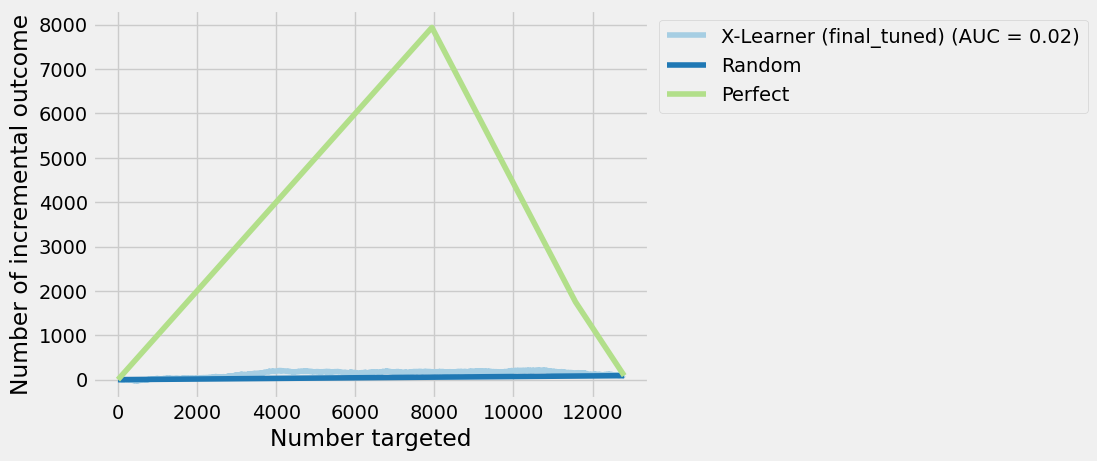

Qini curve saved to: results/x_learner_final_tuned_qini_curve.png


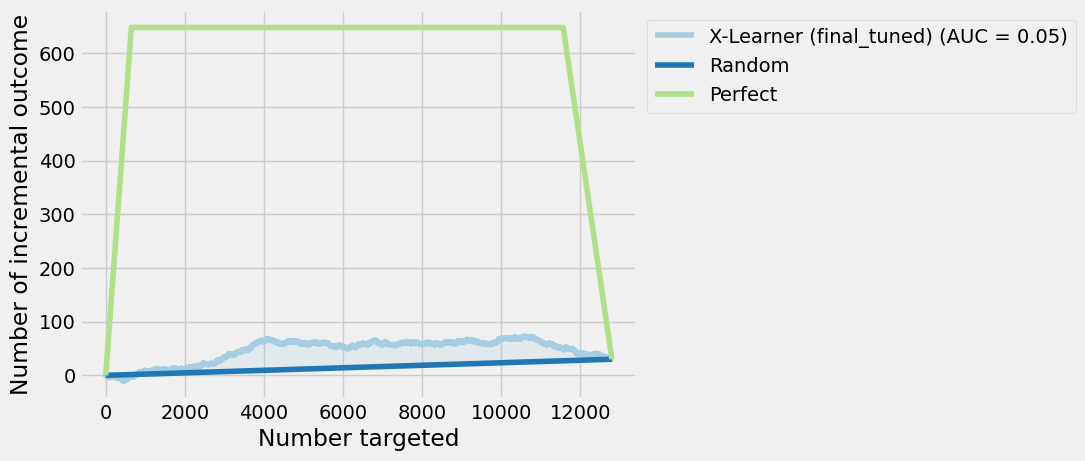

X-Learner model saved to: models/x_learner_final_tuned_model.joblib
Optuna results saved to: results/optuna_hyperopt_results.json


In [35]:
# ---------- Train the final model with best hyperparameters ---------- #

# Extract classifier parameters (prefixed with 'clf_')
best_params_clf = {
    'iterations': study.best_params['clf_iterations'],
    'depth': study.best_params['clf_depth'],
    'learning_rate': study.best_params['clf_learning_rate'],
    'l2_leaf_reg': study.best_params['clf_l2_leaf_reg'],
    'random_seed': 42,
    'verbose': 0,
    'auto_class_weights': 'Balanced'
}

# Extract regressor parameters (prefixed with 'rgs_')
best_params_rgs = {
    'iterations': study.best_params['rgs_iterations'],
    'depth': study.best_params['rgs_depth'],
    'learning_rate': study.best_params['rgs_learning_rate'],
    'l2_leaf_reg': study.best_params['rgs_l2_leaf_reg'],
    'random_seed': 42,
    'verbose': 0
}

print(f"Best Classifier params: {best_params_clf}")
print(f"Best Regressor params: {best_params_rgs}")
print(f"Best Optuna score (Uplift@30%): {study.best_value:.4f}")

# Train final X-Learner with best hyperparameters
x_learner_final = XLearner(best_params_clf, best_params_rgs, control_name=0)
x_learner_final.compute_propensity_scores(X_train_engineered_encoded, X_test_engineered_encoded)
x_learner_final.fit(
    X_train_engineered_encoded, 
    X_test_engineered_encoded, 
    y_train, 
    y_test, 
    X_train_engineered_encoded['treatment']
)
final_uplift = x_learner_final.predict(X_test_engineered_encoded)
_, _, _, metrics_x_learner_final = x_learner_final.evaluate(y_test, X_test_engineered_encoded, 'final_tuned', save_results=True)

# Define params for logging (include Optuna best params)
all_params_x_learner_final = {
    'clf_iterations': best_params_clf['iterations'],
    'clf_depth': best_params_clf['depth'],
    'clf_learning_rate': best_params_clf['learning_rate'],
    'clf_l2_leaf_reg': best_params_clf['l2_leaf_reg'],
    'rgs_iterations': best_params_rgs['iterations'],
    'rgs_depth': best_params_rgs['depth'],
    'rgs_learning_rate': best_params_rgs['learning_rate'],
    'rgs_l2_leaf_reg': best_params_rgs['l2_leaf_reg'],
    'random_seed': 42,
    'optuna_best_score': study.best_value,
    'optuna_n_trials': len(study.trials)
}

# Save final tuned X-Learner model (best model)
x_learner_final.save_model(MODELS_DIR / 'x_learner_final_tuned_model.joblib')

# Save Optuna study results
optuna_results = {
    'best_value': float(study.best_value),
    'best_params': study.best_params,
    'n_trials': len(study.trials)
}
with open(RESULTS_DIR / 'optuna_hyperopt_results.json', 'w') as f:
    json.dump(optuna_results, f, indent=2)
print(f"Optuna results saved to: {RESULTS_DIR / 'optuna_hyperopt_results.json'}")

In [36]:
# ---------- Mlflow logging ---------- #
run_name_x_learner_hyperopt = 'xlearner_hyperopt'

log_to_mlflow(
        EXPERIMENT_NAME,
        run_name_x_learner_hyperopt,
        registry_model_name_x_learner,
        X_train=X_train_engineered_encoded, 
        model=x_learner_final, 
        all_params=all_params_x_learner_final, 
        metrics=metrics_x_learner_final, 
        feature_importances_path=None
    )

/home/mle-user/mle_projects/mle-project-sprint-5/.uplift-venv/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/26 20:29:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'xlearner' already exists. Creating a new version of this model...
2025/1

🏃 View run xlearner_hyperopt at: http://127.0.0.1:5000/#/experiments/21/runs/d9b88ed8b1a9458992ff55cdbacf59c1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/21
MLFlow logging done for xlearner_hyperopt


Результаты X-Learner после one-hot кодирования, инженерии признаков и оптимизации гиперпараметров с помощью Optuna показали существенное улучшение по сравнению с предыдущими результатами. 

Uplift AUC увеличился до 0.02, Qini AUC до 0.05, а Uplift@30 до 0.0486, что указывает на то, что модель теперь лучше ранжирует пользователей по ожидаемому эффекту лечения и способна обеспечивать заметный прирост при таргетировании топ-30% пользователей. 

Результаты X-Learner (Uplift@30 0.0486) также превзошли результаты Baseline CatBoostClassifier (Uplift@30 0.0426), что подчёркивают важность предобработки данных и оптимизации для получения надёжных предсказаний uplift.

## Tuned model results visualization

Uplift by percentile (line) saved to: results/final_uplift_by_percentile_line.png


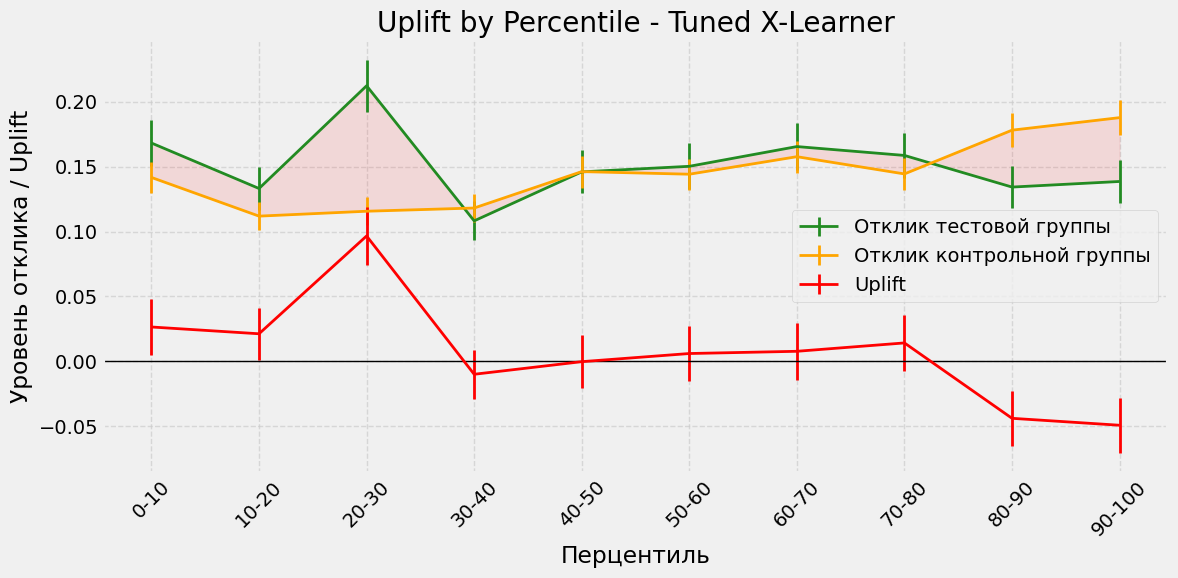

In [37]:
# ---------- Visualize uplift by percentile for tuned model ---------- #
fig = custom_uplift_by_percentile(
    y_true=y_test, 
    uplift=final_uplift.squeeze(), 
    treatment=X_test_engineered_encoded['treatment'],
    kind='line',
    bins=10,
    string_percentiles=True,
    figsize=(12, 6),
    title='Uplift by Percentile - Tuned X-Learner'
)
plt.savefig(RESULTS_DIR / 'final_uplift_by_percentile_line.png', dpi=150, bbox_inches='tight')
print(f"Uplift by percentile (line) saved to: {RESULTS_DIR / 'final_uplift_by_percentile_line.png'}")
plt.show()


Uplift by percentile (bar) saved to: results/final_uplift_by_percentile_bar.png


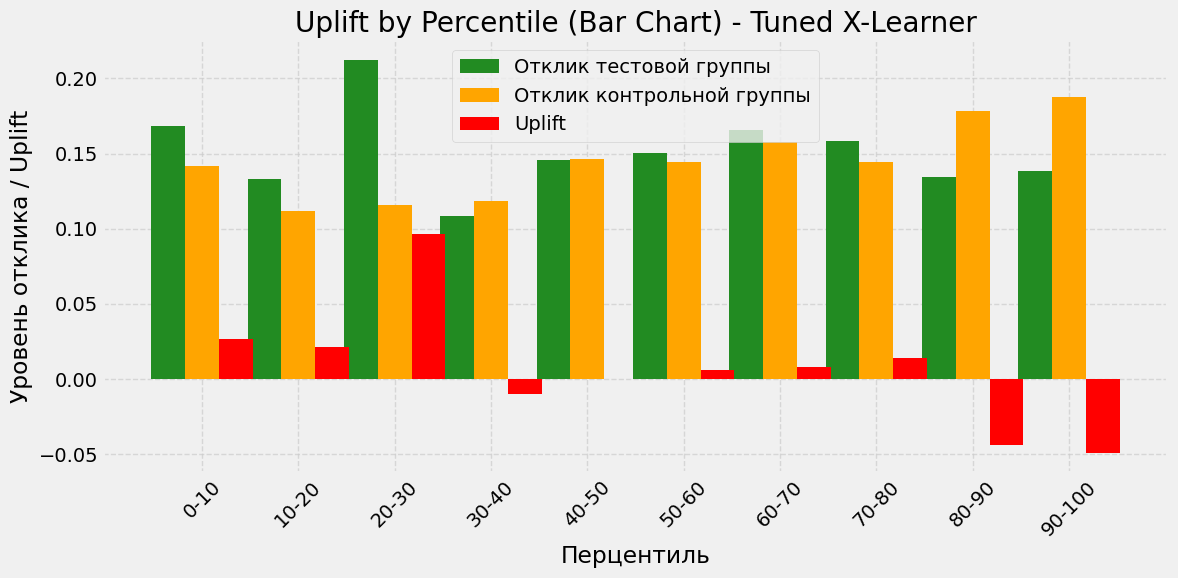

Final uplift curve saved to: results/final_tuned_uplift_curve.png


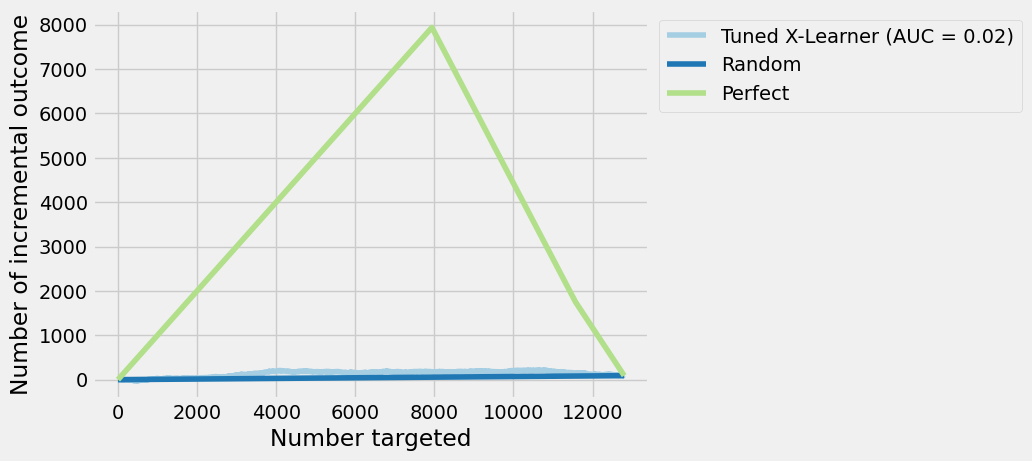

Final Qini curve saved to: results/final_tuned_qini_curve.png


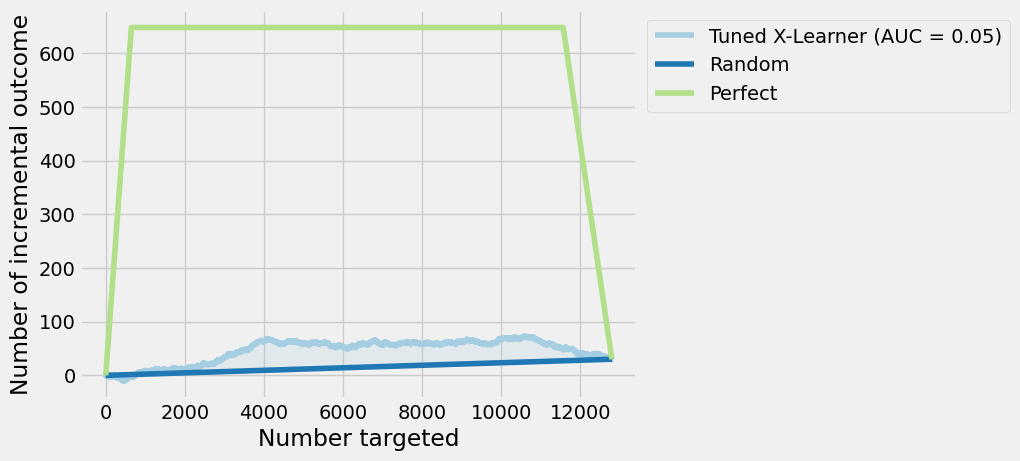

In [38]:
# Compare baseline vs tuned model with bar chart visualization
fig = custom_uplift_by_percentile(
    y_true=y_test, 
    uplift=final_uplift.squeeze(), 
    treatment=X_test_engineered_encoded['treatment'],
    kind='bar',
    bins=10,
    string_percentiles=True,
    figsize=(12, 6),
    title='Uplift by Percentile (Bar Chart) - Tuned X-Learner'
)
plt.savefig(RESULTS_DIR / 'final_uplift_by_percentile_bar.png', dpi=150, bbox_inches='tight')
print(f"Uplift by percentile (bar) saved to: {RESULTS_DIR / 'final_uplift_by_percentile_bar.png'}")
plt.show()

# Plot and save uplift curve
plot_uplift_curve(
    y_test.astype(int).values,
    final_uplift.squeeze(),
    X_test_engineered_encoded['treatment'], 
    name='Tuned X-Learner'
    )
plt.savefig(RESULTS_DIR / 'final_tuned_uplift_curve.png', dpi=150, bbox_inches='tight')
print(f"Final uplift curve saved to: {RESULTS_DIR / 'final_tuned_uplift_curve.png'}")
plt.show()

# Plot and save Qini curve
plot_qini_curve(
    y_test.astype(int).values,
    final_uplift.squeeze(), 
    X_test_engineered_encoded['treatment'], 
    name='Tuned X-Learner'
    )
plt.savefig(RESULTS_DIR / 'final_tuned_qini_curve.png', dpi=150, bbox_inches='tight')
print(f"Final Qini curve saved to: {RESULTS_DIR / 'final_tuned_qini_curve.png'}")
plt.show()

Согласно графикам итоговый X‑Learner даёт положительный uplift только в нижних перцентилях, а в верхних перцентилях эффект становится нулевым или отрицательным:
- В диапазоне примерно 0–30‑го перцентиля тестовая группа показывает более высокий отклик, чем контрольная, а uplift заметно положительный, именно здесь модель находит наибольший эффект от кампании;
- Начиная с 30–40‑го перцентиля uplift колеблется вокруг нуля и в некоторых сегментах уходит в минус, что видно как на линейном, так и на столбчатом графике, для этих пользователей воздействие либо бесполезно, либо потенциально вредно;
- В верхних перцентилях (80–100%) отклик контрольной группы уже выше тестовой, а uplift устойчиво отрицательный, то есть этим пользователям лучше не показывать кампанию, чтобы не ухудшать результат.

Таким образом, в практическом плане модель рекомендует использовать treatment для пользователей из нижних перцентилей uplift‑скоринга (примерно 0–30%), ограничивая или отключая treatment в верхних сегментах, где эффект отсутствует или отрицательный.

In [39]:
# ---------- Summary of all saved models metrics ---------- #
all_metrics = {}
for metrics_file in RESULTS_DIR.glob('metrics_*.json'):
    with open(metrics_file, 'r') as f:
        metrics_data = json.load(f)
        model_name = metrics_data.get('model', metrics_file.stem)
        all_metrics[model_name] = {
            'uplift_auc': metrics_data.get('uplift_auc'),
            'qini_auc': metrics_data.get('qini_auc'),
            'uplift_at_30': metrics_data.get('uplift_at_30')
        }

# Save combined metrics
combined_metrics_path = RESULTS_DIR / 'all_metrics_summary.json'
with open(combined_metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=2)
print(f"\nCombined metrics saved to: {combined_metrics_path}")


Combined metrics saved to: results/all_metrics_summary.json


## Model inference

In [40]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    Принимает сырые данные и выполняет feature engineering + encoding внутри.
    """
    
    def __init__(self, model, raw_feature_names, training_columns, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift (должна иметь метод predict, принимающий numpy array)
            raw_feature_names: Список исходных признаков (до feature engineering)
            training_columns: Список колонок после one-hot encoding (из X_train, без 'treatment')
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.raw_feature_names = raw_feature_names
        # Remove 'treatment' from training columns - not needed for inference
        self.training_columns = [col for col in training_columns if col != 'treatment']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", raw_feature_names)

    def _feature_engineering(self, df):
        """
        Применение feature engineering (аналогично функции features_engineering).
        """
        df_engineered = df.copy()
        
        # Interaction feature: history per recency
        df_engineered['history_per_recency'] = df_engineered['history'] / (df_engineered['recency'] + 1)
        
        # Log transform of history
        df_engineered['log_history'] = np.log1p(df_engineered['history'])
        
        # Customer gender preference
        df_engineered['gender_type'] = df_engineered['mens'].astype(int) + 2 * df_engineered['womens'].astype(int)
        
        # Recency bins
        df_engineered['recency_bin'] = pd.cut(
            df_engineered['recency'], 
            bins=[0, 3, 6, 9, 12], 
            labels=[0, 1, 2, 3]
        ).astype(int)
        
        # History bins
        df_engineered['history_bin'] = pd.qcut(
            df_engineered['history'], 
            q=4, 
            labels=[0, 1, 2, 3], 
            duplicates='drop'
        ).astype(int)
        
        # Newbie and recency interaction
        df_engineered['newbie_recency'] = df_engineered['newbie'].astype(int) * df_engineered['recency']
        
        # High value customer flag (using approximate median from training)
        df_engineered['high_value'] = (df_engineered['history'] > 100).astype(int)
        
        return df_engineered

    def _transform_data(self, X):
        """
        Преобразование данных для модели: feature engineering + one-hot encoding + alignment.
        
        Аргументы:
            X: pandas.DataFrame с сырыми признаками
            
        Возвращает:
            numpy.ndarray: Преобразованные данные для модели
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # Step 1: Select only required raw features
        X = X[self.raw_feature_names].copy()
        
        # Step 2: Apply feature engineering
        X_engineered = self._feature_engineering(X)
        
        # Step 3: One-hot encoding
        cat_to_encode = [
            'history_segment', 
            'zip_code', 
            'channel', 
            'gender_type', 
            'recency_bin', 
            'history_bin'
        ]
        
        for col in cat_to_encode:
            if col in X_engineered.columns:
                X_engineered[col] = X_engineered[col].astype(str)
        
        X_encoded = pd.get_dummies(X_engineered, columns=cat_to_encode, drop_first=True)
        
        # Step 4: Align columns with training data
        # Add missing columns (filled with 0)
        for col in self.training_columns:
            if col not in X_encoded.columns:
                X_encoded[col] = 0
        
        # Keep only training columns in the correct order
        X_encoded = X_encoded[self.training_columns]
        
        return X_encoded.values
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с сырыми признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых RAW признаков
        missing_features = set(self.raw_feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)
            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X_transformed = self._transform_data(X)
        
        # Вычисляем propensity scores для новых данных
        if self.logger:
            self.logger.debug("Вычисляем propensity scores")
        
        # Use the stored propensity model to compute scores for new data
        propensity_scores = self.model.propensity_model.predict_proba(X_transformed)[:, 1]
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        
        # Get uplift predictions from the model's internal x_learner with propensity scores
        uplift = self.model.x_learner.predict(X_transformed, p=propensity_scores).squeeze()
        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [41]:
# Initialize the inference model with trained X-Learner
# Raw features expected as input (before feature engineering)
raw_feature_names = [
    'recency', 
    'history_segment', 
    'history', 
    'mens', 
    'womens', 
    'zip_code', 
    'newbie', 
    'channel'
]

# Training columns after feature engineering and encoding (excluding 'treatment')
training_columns = list(X_train_engineered_encoded.columns)

model_inference = UpliftModelInference(
    model=x_learner_final,
    raw_feature_names=raw_feature_names,
    training_columns=training_columns
)
print(f"Model initialized with {len(raw_feature_names)} raw features")
print(f"Model expects {len(model_inference.training_columns)} encoded features after transformation")

Model initialized with 8 raw features
Model expects 27 encoded features after transformation


In [42]:
# Create test data with raw features
test_data = pd.DataFrame({
    'recency': [1, 2, 3],
    'history_segment': [1, 2, 3], 
    'history': [100, 200, 300],
    'mens': [1, 0, 1],
    'womens': [0, 1, 0],
    'zip_code': [1, 0, 1],
    'newbie': [0, 1, 0],
    'channel': [1, 2, 0]
})

print('Test data (raw features):')
display(test_data)

Test data (raw features):


,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,1,1,100,1,0,1,0,1
1,2,2,200,0,1,0,1,2
2,3,3,300,1,0,1,0,0


In [43]:
# ---------- Inference check---------- #
predictions = model_inference.predict(test_data)
print('Uplift predictions for test data:')
print(predictions)

Uplift predictions for test data:
[-0.20192418 -0.10694179 -0.26839771]
